# Predicting Airline Delays


[T26 Presentation Slides](https://docs.google.com/presentation/d/1ysKMTZ2oNc-V1mGM7UaNlF-tOwEizasFbi2A5zdwqDE/edit#slide=id.gcdefe32489_3_0)

## Airline: Bureau of Transportation Statistics
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

2015 - 2019

## Weather
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00532

# 1. Question Formulation
> _You should refine the question formulation based on the general task description you’ve been given, ie, predicting flight delays. This should include some discussion of why this is an important task from a business perspective, who the stakeholders are, etc.. Some literature review will be helpful to figure out how this problem is being solved now, and the State Of The Art (SOTA) in this domain. Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful. Discuss evaluation metrics._

The goal of the modeling effort laid out in this notebook is to predict delayed flight departures 2 hours before they happen. The Federal Aviation Administration (FAA) defines a delay as a flight that leaves more than 15 minutes after its scheduled departure time. This is important because delays are very costly. Being able to predict them can allow airlines to take proactive measures to minimize their impact. It can also allow them to notify their customers and increase customer satisfaction. 

**Economic Impact of Delays**

According to FAA estimates ([source](https://www.faa.gov/data_research/aviation_data_statistics/media/cost_delay_estimates.pdf)), delays on US domestic flights **cost 33 billion dollars** in 2019. Compare that with the **14.8 billion in total profits** for all carriers on US domestic flights in 2019 ([source](https://www.bts.gov/newsroom/2019-annual-and-4th-quarter-us-airline-financial-data)).  Of the 33 billion dollars in loss:
- 8.3 billion was direct costs borne by the airlines
- 18 billion was costs that the passengers ended up taking on
- 4.2 billion was costs to non-airline businesses
- 2.4 billion was lost because the prospect of delayse made passengers choose not to fly.

![Cost of Delays Chart](https://raw.githubusercontent.com/blulightspecial/images/main/DelayCosts.png)

**Specific Prediction Goal**

> Two hours before its departure, our model will predict whether a flight is delayed by 15+ minutes. To do so, we will use airport data from 2015 to 2019, augmented with weather reports available at the time of the prediction. As a secondary goal, we will aim to understand what specific factors are strong predictors of delays. 


**Evaluation Metric - F0.5 score**  
  - If we focus on precision as our performance metric, we will end up missing lots of delayed flights, but we will raise very few delay notifications incorrectly. In the degenerate case, we would end up saying that almost nothing is delayed (except the 1 flight going out of o'hare on thanksgiving in a snowstorm) and we would end up with a good performance according to this metric. 
  - It’s worth noting that accuracy (which is total correct predictions over total predictions) has a similar degenerate case to precision. This is because we have many more non-delayed flights than delayed flights. If we always predict flights will be on time and never delayed, we will end up with 80% accuracy. 
  - If we focus on recall as our performance metric, we will end up saying that a lot of flights that actually end up leaving on times, are delayed. However we will miss very few delayed flights. In the degenerate case, if we labeled everything as being delayed we would end up with perfect performance according to this metric. 
  - Because of these degenerate cases, we choose the F score, which is a weighted average of the precision and the recall. If either precision or recall drops then the F score drops as well, there is no degenerate case where always predicting delayed or always predicting on time will give good performance. We specifically choose the F0.5 score instead of the F1 or F2 score because it weighs precision more heavily than recall. In our use case, the client uses these delay predictions to send alerts to passengers. If a passenger is told that their flight will be delayed, they will change their behavior accordingly and may miss on-time departing flights or may actually cause delays as a result. 

 As discussed above, delayed flights have huge financial implications to the airline industry. As such, being able to anticipate even a fraction of delayed flights can generate impact, appreciating that the costs of implementing such a prediciton model in production is not cost-free. As such, we believe that being able to predict half of delays would help generate substantial savings. We will be able to identify when that goal is reached when plotting the confusion matrix. 
 
 
**[Literature Review Table](https://docs.google.com/document/d/1k9Ceihm-JLEgKBLkgOFCzzmqjhdM4aYmF7HflgFVRug/edit?usp=sharing)**  
A brief review of the literature allowed us to get an intuition for models that would be most successful. Indeed, the majority of the articles we read show tree models as being the ones ussed for studying flight delays. In addition, published articles on flight delays confirmed out intuition that delays propagate, that is that one late arrival leads the a follow delayed departure. Models like chained delay propagation are used, and this informs that our feature engineering will have to capture previous delay events in some form. An overview of the results from the literature is provided in the link above.

# 2. EDA & Discussion of Challenges
> _Determine a handful of relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform._

We have selected a few EDA tasks to highlight in the main report. First we look at the number of outcomes from our train dataset from 2015 to 2018. This information will give us an idea of how many flights are non-delays, delays, and cancelled. Then we look at the correlation matrix of the weather variables of interest. Finally, we look at variation of delayed flights by geography and  by carrier. More EDA was done in this [EDA Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441171345/command/1553213441186306) and the more complex visualizations were done in these [6m Visualization Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/528073926732403/command/37954262503407) and [Visualization Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120644993/command/1553213441183818).

From our EDA we can see that there are a lot of variables in both datasets. Reducing the number of variables would be beneficial to speed up computational time, but we cannot simply throw data away carelessly. For the airline data, a lot of variables are highly correlated to each other. One example of this is `CRS_ELAPSED_TIME` (Computer Reservation Systems elapsed time) and `DISTANCE` (distance between airports). In this case, the CRS elapsed time would correlate to the distance between the airports: the farther apart the airports, the longer the scheduled elapsed time. On the other hand, the weather data has a lot of variables that provide highly granular information. However, not all of the variables have values and many reports provide duplicate information. We will have to be careful about how we select which variables to keep and which variables to discard in order to extract the most useful information. Additionally, we will need to carefully parse the weather data as each column contains multiple values. Further discussion on feature selection and engineering will be discussed in the next section. 

Beyond feature selection, one of the biggest challenges will come from working with the time series data and ensuring that no leakage occurs. The airline dataset itself contains variables that should not be available at our prediction time 2 hours before scheduled departure. Some examples of such variables are the number of actual departure delay minutes and possibly previous arrival delay minutes. However, many of these variables would still be important to keep as they would provide valuable information to our model. Previous arrival delay minutes in particular would be important to keep as a late arriving aircraft could cause a departure delay and even cause a chain of delays down the line. We will have to remove the actual values and somehow impute them based on data that is available to us before or at the prediction time. Similarly we will have to be careful about how we join the airline data with the weather data and how we impute missing data. We cannot associate data with a sample in such a way that future information is available to us within the prediction time and the scheduled departure time. 

Finally, the outcome variable is very imbalanced with a large majority of flights being non-delays. One challenge will be addressing this imbalance when training our model. Neglecting to address this class imbalance would have detrimental effects on our models due to the very nature of the algorithms themselves. For example, when building tree-based models, the algorithm builds logical rules to split the dataset from parent nodes to children nodes to increase purity of observations until we filter the data into homogenous groups. With imbalanced data, majority of the initial splits along the tree will most likely splitting majority classes and not the minority class. Similarly, any model that uses gradient descent to minimize loss will be subject to frequency bias and will work more on correctly classifying the majority class.

## 2.1 Imports

In [0]:
# Imports
import re
import time
import datetime as dt
import numpy as np
import pandas as pd
# import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
# from pyspark.sql.types import *
# from pyspark.sql.functions import *
from pyspark.sql import functions as f
from pyspark.sql.functions import trim
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.sql import Window
from pyspark.sql.functions import when, count, col
from pyspark.sql.functions import substring

import pytz

from pyspark.sql.functions import countDistinct
import itertools

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import GBTClassificationModel 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler,VectorSlicer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, fbeta_score
from sklearn.metrics import confusion_matrix

from pyspark.sql.functions import when, count, col
from pyspark.sql.functions import expr
from pyspark.sql.functions import unix_timestamp, from_unixtime

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator , CrossValidatorModel
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import time
import datetime

import random
from functools import reduce
from pyspark.sql import Row
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.functions import to_utc_timestamp
from pyspark.sql.functions import year, quarter, month, hour, dayofmonth, dayofweek
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
import graphframes as GF
import pyspark.sql.types as T
import itertools
import seaborn as sn
import itertools

## Install altair and vega_datasets if necessary
!pip install altair
!pip install vega_datasets

## Import necessary libraries
import altair as alt
from vega_datasets import data


sqlContext = SQLContext(sc)

Collecting altair
 Downloading altair-4.1.0-py3-none-any.whl (727 kB)
▌ | 10 kB 41.4 MB/s eta 0:00:01 |█ | 20 kB 39.8 MB/s eta 0:00:01 |█▍ | 30 kB 19.3 MB/s eta 0:00:01 |█▉ | 40 kB 23.1 MB/s eta 0:00:01 |██▎ | 51 kB 21.7 MB/s eta 0:00:01 |██▊ | 61 kB 17.5 MB/s eta 0:00:01 |███▏ | 71 kB 17.7 MB/s eta 0:00:01 |███▋ | 81 kB 19.5 MB/s eta 0:00:01 |████ | 92 kB 19.2 MB/s eta 0:00:01 |████▌ | 102 kB 18.7 MB/s eta 0:00:01 |█████ | 112 kB 18.7 MB/s eta 0:00:01 |█████▍ | 122 kB 18.7 MB/s eta 0:00:01 |█████▉ | 133 kB 18.7 MB/s eta 0:00:01 |██████▎ | 143 kB 18.7 MB/s eta 0:00:01 |██████▊ | 153 kB 18.7 MB/s eta 0:00:01 |███████▏ | 163 kB 18.7 MB/s eta 0:00:01 |███████▋ | 174 kB 18.7 MB/s eta 0:00:01 |████████ | 184 kB 18.7 MB/s eta 0:00:01 |████████▌ | 194 kB 18.7 MB/s eta 0:00:01 |█████████ | 204 kB 18.7 MB/s eta 0:00:01 |█████████▌ | 215 kB 18.7 MB/s eta 0:00:01 |██████████ | 225 kB 18.7 MB/s eta 0:00:01 |██████████▍ | 235 kB 18.7 MB/s eta 0:00:01 |██████████▉ | 245 kB 18.7 MB/s eta 0:00:01 |███████████▎ | 256 kB 18.7 MB/s eta 0:00:01 |███████████▊ | 266 kB 18.7 MB/s eta 0:00:01 |████████████▏ | 276 kB 18.7 MB/s eta 0:00:01 |████████████▋ | 286 kB 18.7 MB/s eta 0:00:01 |█████████████ | 296 kB 18.7 MB/s eta 0:00:01 |█████████████▌ | 307 kB 18.7 MB/s eta 0:00:01 |██████████████ | 317 kB 18.7 MB/s eta 0:00:01 |██████████████▍ | 327 kB 18.7 MB/s eta 0:00:01 |██████████████▉ | 337 kB 18.7 MB/s eta 0:00:01 |███████████████▎ | 348 kB 18.7 MB/s eta 0:00:01 |███████████████▊ | 358 kB 18.7 MB/s eta 0:00:01 |████████████████▏ | 368 kB 18.7 MB/s eta 0:00:01 |████████████████▋ | 378 kB 18.7 MB/s eta 0:00:01 |█████████████████ | 389 kB 18.7 MB/s eta 0:00:01 |█████████████████▋ | 399 kB 18.7 MB/s eta 0:00:01 |██████████████████ | 409 kB 18.7 MB/s eta 0:00:01 |██████████████████▌ | 419 kB 18.7 MB/s eta 0:00:01 |███████████████████ | 430 kB 18.7 MB/s eta 0:00:01 |███████████████████▍ | 440 kB 18.7 MB/s eta 0:00:01 |███████████████████▉ | 450 kB 18.7 MB/s eta 0:00:01 |████████████████████▎ | 460 kB 18.7 MB/s eta 0:00:01 |████████████████████▊ | 471 kB 18.7 MB/s eta 0:00:01 |█████████████████████▏ | 481 kB 18.7 MB/s eta 0:00:01 |█████████████████████▋ | 491 kB 18.7 MB/s eta 0:00:01 |██████████████████████ | 501 kB 18.7 MB/s eta 0:00:01 |██████████████████████▌ | 512 kB 18.7 MB/s eta 0:00:01 |███████████████████████ | 522 kB 18.7 MB/s eta 0:00:01 |███████████████████████▍ | 532 kB 18.7 MB/s eta 0:00:01 |███████████████████████▉ | 542 kB 18.7 MB/s eta 0:00:01 |████████████████████████▎ | 552 kB 18.7 MB/s eta 0:00:01 |████████████████████████▊ | 563 kB 18.7 MB/s eta 0:00:01 |█████████████████████████▏ | 573 kB 18.7 MB/s eta 0:00:01 |█████████████████████████▋ | 583 kB 18.7 MB/s eta 0:00:01 |██████████████████████████▏ | 593 kB 18.7 MB/s eta 0:00:01 |██████████████████████████▋ | 604 kB 18.7 MB/s eta 0:00:01 |███████████████████████████ | 614 kB 18.7 MB/s eta 0:00:01 |███████████████████████████▌ | 624 kB 18.7 MB/s eta 0:00:01 |████████████████████████████ | 634 kB 18.7 MB/s eta 0:00:01 |████████████████████████████▍ | 645 kB 18.7 MB/s eta 0:00:01 |████████████████████████████▉ | 655 kB 18.7 MB/s eta 0:00:01 |█████████████████████████████▎ | 665 kB 18.7 MB/s eta 0:00:01 |█████████████████████████████▊ | 675 kB 18.7 MB/s eta 0:00:01 |██████████████████████████████▏ | 686 kB 18.7 MB/s eta 0:00:01 |██████████████████████████████▋ | 696 kB 18.7 MB/s eta 0:00:01 |███████████████████████████████ | 706 kB 18.7 MB/s eta 0:00:01 |███████████████████████████████▌| 716 kB 18.7 MB/s eta 0:00:01 |████████████████████████████████| 727 kB 18.7 MB/s eta 0:00:01 |████████████████████████████████| 727 kB 18.7 MB/s 
Requirement already satisfied: jinja2 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from altair) (2.11.1)
Collecting jsonschema
 Downloading jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
█████▉ | 10 kB 47.6 MB/s eta 0:00:01 |███████████▋ | 20 kB 58.5 MB/s eta 0:00:01

## 2.2 Read in Data

In [0]:
# Airline 
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/201*.parquet")

###########################################################################################################################################

# Weather
weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet/")

###########################################################################################################################################

# Page Rank
PR = spark.read.parquet("/output/model/data_w_pr.parquet")

###########################################################################################################################################

# OPEN FLIGHTS DATABSE
## Read in the airport location data
# File location and type
file_location = "/FileStore/tables/open_flight_database.txt"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

open_flights = df.withColumnRenamed("_c0", "id")\
            .withColumnRenamed("_c1", "airport")\
            .withColumnRenamed("_c2", "city")\
            .withColumnRenamed("_c3", "country")\
            .withColumnRenamed("_c4", "of_IATA")\
            .withColumnRenamed("_c5", "of_ICAO")\
            .withColumnRenamed("_c6", "lat")\
            .withColumnRenamed("_c7", "lon")\
            .withColumnRenamed("_c8", "alt")\
            .withColumnRenamed("_c9", "tz")\
            .withColumnRenamed("_c10", "dst")\
            .withColumnRenamed("_c11", "tz_db_tz")\
            .withColumnRenamed("_c12", "type")\
            .withColumnRenamed("_c13", "source")\

# Filter Down to just US airports
open_flights = open_flights.filter(open_flights.country=='United States')

open_flights_IATA_ICAO = open_flights.select('of_IATA', 'of_ICAO')

###########################################################################################################################################

#IATA
# File location and type
file_location = "/FileStore/tables/T26/iata_tz.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

iata_tz = df.withColumnRenamed("_c0", "IATA")\
            .withColumnRenamed("_c1", "TZ")\

In [0]:
# subset so that we do not perform EDA on our test data

# AIRLINE DATA
# only select certain columns of data
keep_columns = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_TIME_BLK', 'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

airlines_EDA = airlines.select(*keep_columns)

airlines_EDA = airlines_EDA.filter(airlines_EDA['YEAR'] < 2019)

# join with open flight database
# join on ORIGIN
airlines_EDA = airlines_EDA.join(open_flights_IATA_ICAO, (airlines_EDA.ORIGIN == open_flights_IATA_ICAO.of_IATA), how='left')
airlines_EDA = airlines_EDA.withColumnRenamed('of_IATA', 'ORIGIN_IATA')\
                             .withColumnRenamed('of_ICAO', 'ORIGIN_ICAO')
# join on DEST
airlines_EDA = airlines_EDA.join(open_flights_IATA_ICAO, (airlines_EDA.DEST == open_flights_IATA_ICAO.of_IATA), how='left')
airlines_EDA = airlines_EDA.withColumnRenamed('of_IATA', 'DEST_IATA')\
                             .withColumnRenamed('of_ICAO', 'DEST_ICAO')

###########################################################################################################################################

# WEATHER DATA
for c_name in weather.columns:
    weather = weather.withColumn(c_name, trim(c_name))

#exclude_records = ['SOM', 'SOD', 'CRN05', 'CRN15', 'BRAZ', 'AUST', 'PCP15', 'PCP60', 'COOPD', 'BOGUS', 'GREEN', #'MEXIC', 'FM-12', 'FM-13', 'FM-14', 'FM-18']
keep_records = ['FM-15', 'FM-16', 'PCP60', 'SA-AU', 'SAO']
weather_EDA = weather.filter(weather['REPORT_TYPE'].isin(keep_records))

# generate list of airlines to filter weather data by
origin_array = [i.ORIGIN_ICAO for i in airlines_EDA.select('ORIGIN_ICAO').distinct().collect()]
dest_array = [i.DEST_ICAO for i in airlines_EDA.select('DEST_ICAO').distinct().collect()]
airport_list = set(origin_array + dest_array)

# filter to match airports (drop international stations)
weather_EDA = weather_EDA.filter(weather_EDA['CALL_SIGN'].isin(airport_list))

# recast weather DATE as datetime
weather_EDA = weather_EDA.withColumn('DT_DATE', to_timestamp(weather_EDA.DATE))

# create year column
weather_EDA = weather_EDA.withColumn('weather_year', year('DT_DATE'))

# filter to train (2015 to 2018 data)
weather_EDA = weather_EDA.filter((weather_EDA.weather_year > 2014) & (weather_EDA.weather_year < 2019))

keep_columns_weather = ['STATION', 'DATE', 'SOURCE', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP']
weather_EDA = weather_EDA.select(*keep_columns_weather)

weather_EDA = weather_EDA.withColumn('WND_SPLIT', f.split(col('WND'), ","))\
                           .withColumn('WND_NEW', f.col('WND_SPLIT')[3])\
                           .withColumn('CIG_SPLIT', f.split(col('CIG'), ","))\
                           .withColumn('CIG_NEW', f.col('CIG_SPLIT')[0])\
                           .withColumn('VIS_SPLIT', f.split(col('VIS'), ","))\
                           .withColumn('VIS_NEW', f.col('VIS_SPLIT')[0])\
                           .withColumn('TMP_SPLIT', f.split(col('TMP'), ","))\
                           .withColumn('TMP_NEW', f.col('TMP_SPLIT')[0])\
                           .withColumn('DEW_SPLIT', f.split(col('DEW'), ","))\
                           .withColumn('DEW_NEW', f.col('DEW_SPLIT')[0])\
                           .withColumn('SLP_SPLIT', f.split(col('SLP'), ","))\
                           .withColumn('SLP_NEW', f.col('SLP_SPLIT')[0])

weather_EDA = weather_EDA.withColumn('WND_INT', weather_EDA.WND_NEW.cast('float'))\
                 .withColumn('CIG_INT', weather_EDA.CIG_NEW.cast('float'))\
                 .withColumn('VIS_INT', weather_EDA.VIS_NEW.cast('float'))\
                 .withColumn('TMP_INT', weather_EDA.TMP_NEW.cast('float'))\
                 .withColumn('DEW_INT', weather_EDA.DEW_NEW.cast('float'))\
                 .withColumn('SLP_INT', weather_EDA.SLP_NEW.cast('float'))

drop_columns = ["WND", "CIG", "VIS", "TMP", "DEW", "SLP", "WND_SPLIT", "WND_NEW", "CIG_SPLIT", "CIG_NEW", "VIS_SPLIT", "VIS_NEW", "TMP_SPLIT", "TMP_NEW", "DEW_SPLIT", "DEW_NEW", "SLP_SPLIT", "SLP_NEW"]

weather_EDA = weather_EDA.drop(*drop_columns)

## 2.3 EDA

In [0]:
airlines_EDA = airlines_EDA.withColumn("OUTCOME",
                      f.when(f.col("DEP_DEL15") == 0, "on_time")\
                       .when(f.col("DEP_DEL15") == 1, "delayed")\
                       .when(f.col("CANCELLED") == 1, "cancelled")\
                       .otherwise("null")
                      )

# airlines_6m_df = airlines_6m.toPandas()

# plot number of on time/delayed/cancelled flights in total
# sns.countplot(x=airlines_EDA['OUTCOME'], palette=['#FF5C1B', '#3FB20D', '#1C81C9']).set_title("Number of Flights")
display(airlines_EDA.groupBy("OUTCOME").count().sort('OUTCOME'))

OUTCOME,count
cancelled,342442
delayed,4331377
null,4744
on_time,19646241


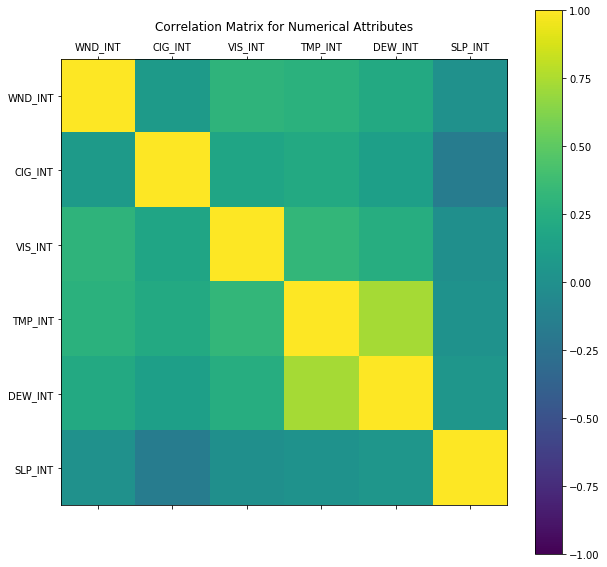

In [0]:
#columns = ['WND_INT', 'CIG_INT', 'VIS_INT', 'TMP_INT', 'DEW_INT', 'SLP_INT']
weather_EDA_corr = weather_EDA.select(columns)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols = weather_EDA_corr.columns, outputCol = vector_col)
df_vector = assembler.transform(weather_EDA_corr).select(vector_col)

# get correlation matrix
# display(matrix = Correlation.corr(df_vector, vector_col))
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

def plot_corr_matrix(correlations,attr):
    fig=plt.figure(figsize=(10, 10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Numerical Attributes in Weather Data 2015-2018")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns)

In [0]:
#This EDA was based on cleaned data from Section 3. 
train = spark.read.parquet("/output//airline_weather_joined_train_full.parquet")

df_delay = train.groupBy('ORIGIN_STATE_ABR').agg({'DEP_DEL15_RECODE': 'mean'}).toPandas()
df_delay.set_index("ORIGIN_STATE_ABR",inplace = True)
# df_delay

df_FIPS = pd.read_csv("https://gist.githubusercontent.com/blulightspecial/f623ef4272add92a4c2336994d87ba56/raw/3944d2d3b06fa2dd929c0f26afc81cf5e656e689/StateFips.csv")
df_FIPS.set_index("Postal Code", inplace = True)
# df_FIPS

df_joined = df_delay.join(df_FIPS, how='left').reset_index().rename(columns={"avg(DEP_DEL15_RECODE)":"pctDelay"})
# df_joined

import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')

alt.Chart(df_joined).mark_geoshape(stroke="white").encode(
    shape='geo:G',
    color=alt.Color('pctDelay:Q', 
                    scale =alt.Scale(scheme = "redyellowgreen", reverse=True), 
                    legend = alt.Legend(title= "Pct Delayed", format = ".0%")),
).transform_lookup(
    lookup='FIPS',
    from_=alt.LookupData(data=states, key='id'),
    as_='geo'
).properties(
    width=800,
    height=450,
).project(
    type='albersUsa'
).properties(title = {
      "text": ["Percent Outgoing Delayed Flights by State for US Domestic Flights"], 
      "subtitle": ["Flights Jan 2015 thru Dec 2018"],
      "fontSize": 24,
      "subtitleFontSize": 16,
      "subtitleColor": "darkgrey"
    })

Out[32]:

In [0]:
#This EDA was based on cleaned data from Section 3.
df_carrier = train.groupBy('OP_CARRIER_AIRLINE_ID').agg({'DEP_DEL15_RECODE': 'mean'}).toPandas()
df_carrier.set_index("OP_CARRIER_AIRLINE_ID",inplace = True)

airline_dict = {19386: ("Northwest", "NW")
,19391: ("Pac SW", "PS")
,19393: ("Sthwst", "WN")
,19678: ("Aloha", "AQ")
,19687: ("Horizon", "QX")
,19690: ("Hawaiian", "HA")
,19704: ("Continental","CO")
,19707: ("Eastern","EA")
,19790: ("Delta", "DL")
,19805: ("American", "AA")
,19822: ("Piedmont", "PI")
,19930: ("Alaska", "AS")
,19977: ("United", "UA")
,19991: ("America West", "HP")
,20211: ("Trans World", "TW")
,20295: ("Midway", "ML")
,20304: ("SkyWst", "OO")
,20312: ("ATA", "TZ")
,20355: ("US Air", "US")
,20363: ("Endeavor", "9E")
,20366: ("ExJet", "EV")
,20368: ("Allegiant", "G4")
,20374: ("ExJet", "XE")
,20378: ("Mesa Air", "YV")
,20384: ("Pan Am", "PA")
,20397: ("PSA", "OH")
,20398: ("Envoy", "MQ")
,20404: ("Independence", "DH")
,20409: ("JetBlue", "B6")
,20416: ("Spirit", "NK")
,20417: ("Comair", "OH")
,20436: ("Frontier", "F9")
,20437: ("AirTran", "FL")
,20452: ("Republic", "YX")
,21171: ("Virgin", "VX")}

air_dict_abrev = {k:v[1] + " - " +v[0] for k,v in airline_dict.items()}

df_carrier.rename(index=air_dict_abrev, inplace=True)

df_carrier.reset_index(inplace=True)

df_carrier.rename(columns={"OP_CARRIER_AIRLINE_ID":"AIRLINE", "avg(DEP_DEL15_RECODE)":"pctDelayed"}, inplace=True)

df_carrier.sort_values("pctDelayed", inplace=True)


alt.Chart(df_carrier).mark_bar(color="orange").encode(
    x=alt.Y("AIRLINE:N",axis=alt.Axis(title='Carrier Name')),
    y=alt.Y("pctDelayed:Q",axis=alt.Axis(format='%', title='Percent of Flights Delayed')),
).properties(
    width=450,
    height=200,
).properties(title = {
      "text": ["Percent Delayed Flights by Carrier for US Domestic Flights"], 
      "subtitle": ["Flights Jan 2015 thru Dec 2018"],
      "fontSize": 16,
      "subtitleFontSize": 13,
      "subtitleColor": "darkgrey"
    })

Out[33]:

# 3. Feature Engineering
> _Apply relevant feature transformations, dimensionality reduction if needed, interaction terms, treatment of categorical variables, etc.. Justify your choices_

[Feature Engineering Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/295347005521093/command/439895120639170)

[PageRank Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120647111/command/439895120647112)

The first step in our Feature Engineering pipeline is to filter the data so that we are only keeping relevant information. We also need to add a few variables to facilitate a join with the weather data. Local time is converted to UTC time and the airport's IACO code is added (IATA code is already in there it corresponds to `ORIGIN` and `DESTINATION` variables). Once this is done we can join the airline delay informaiton with the weather information. At this point we can impute any missing weather data, and add our engineered variables such as layover time and previous delay. We also run PageRank monthly to determine an airport's centrality in the US flight graph over time. As a last step before we run our model, we use target encoding to convert categorical variables to numeric variables that represent the mean outcome for each given category. This reduceds our feature space and allows faster model training, but did not have a significant impact on our F0.5 performance metric. 

**Overview of Feature Engineering Steps**
- Filter Data
  - Airline data
    - Keep a subset of the data (a lot of variables are very similar/closely related such as DEP_DEL and DEP_DEL_NEW, etc.)
    - Join with IATA/ICAO and timezone database (for later join and UTC time calculation)
    - Convert date and time to UTC, slightly modify some variables (i.e. offset UTC time by 3 hours), generate some variables of interest (ARR_TIME_GAP, PREV_DEP_DEL, PREV_ARR_DEL, etc.)
  - Weather data
    - Keep only certain report types
    - Keep only stations that match list of origin and destination airports
    - Keep only a few variables of interest and extract the value from the list of information in each cell
- Modify Data and Add Vars
- Join Data
  - Join the airlines and weather data on ICAO/weather station, date, hour of report that matches 3 hours earlier than scheduled departure time
  - Join the combined airline/weather data and PageRank data on ORIGIN, YEAR, MONTH and on DEST, YEAR, MONTH
- Split into Train and Test
- Impute and Add More Vars
  - Impute weather data by windowing from -9 days to -2 days and taking the average over that week
  - Impute previous PREV_DEP_DEL and PREV_ARR_DELAY by simply 
- Target encoding replaces categorical variables with numerics. It does this by takig the average value of the outcome associated with that variable in the training set and replacing the categorical with that mean. When it encounters a variable in the test set that it hasn't seen in the training set, it uses the grand mean value in those instances.  It's important that the training data is the one being used to generate these means and that teh test is only getting values from the training. Becasue of this, target encoding happens right before the model training and evaluation.

d  ## 3.1 Filter and Modify Data

In [0]:
def recode_airlines(toRecode, window):
  '''
  function to filter, recode, extract data from weather dataset
  '''
  #d15null = 1
  d15null = 0
  
  keep_columns = ['FL_DATE','OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_MARKET_ID','ORIGIN', 'DEST', 'ORIGIN_STATE_ABR','DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEST_STATE_ABR', 'CRS_DEP_TIME','DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_DEL15', 'CRS_ELAPSED_TIME', 'CANCELLED', 'CANCELLATION_CODE','FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
  
  toRecode = toRecode.select(*keep_columns)

  recoded = toRecode.withColumn('DEP_DEL15_RECODE', (when(col("DEP_DEL15").isNull(), d15null)\
                                                     .otherwise(col("DEP_DEL15"))))\
                     .withColumn('ARR_DEL15_RECODE', (when(col("ARR_DEL15").isNull(), d15null)\
                                                                .otherwise(col("ARR_DEL15"))))\
                    .withColumn('TAIL_NUM_RECODE', (when(col("TAIL_NUM").isNull(), 2)\
                                                     .otherwise(col("TAIL_NUM"))))\
                    .withColumn('CANCELLED_RECODE', (when(col("CANCELLED").isNull(), 2)\
                                                     .otherwise(col("CANCELLED"))))\
                    .withColumn('CANCELLATION_CODE_RECODE', (when(col("CANCELLATION_CODE").isNull(), 2)\
                                                     .otherwise(col("CANCELLATION_CODE"))))\
                    .withColumn('CARRIER_DELAY_RECODE', (when(col("CARRIER_DELAY").isNull(), 0)\
                                                     .otherwise(col("CARRIER_DELAY"))))\
                    .withColumn('WEATHER_DELAY_RECODE', (when(col("WEATHER_DELAY").isNull(), 0)\
                                                     .otherwise(col("WEATHER_DELAY"))))\
                    .withColumn('NAS_DELAY_RECODE', (when(col("NAS_DELAY").isNull(), 0)\
                                                     .otherwise(col("NAS_DELAY"))))\
                    .withColumn('SECURITY_DELAY_RECODE', (when(col("SECURITY_DELAY").isNull(), 0)\
                                                     .otherwise(col("SECURITY_DELAY"))))\
                    .withColumn('LATE_AIRCRAFT_DELAY_RECODE', (when(col("LATE_AIRCRAFT_DELAY").isNull(), 0)\
                                                     .otherwise(col("LATE_AIRCRAFT_DELAY"))))\
                    .withColumn('FL_DAY_OF_WEEK', dayofweek(col('FL_DATE')))\
                    .withColumn('FL_WEEKEND', when((col("FL_DAY_OF_WEEK")==6) | (col("FL_DAY_OF_WEEK")==7), 1).otherwise(0))\
                    .withColumn("DEP_TIME_STRING", f.format_string("%04d", f.col("CRS_DEP_TIME")))\
                    .withColumn("DEP_TIME_STRING",f.concat_ws(":",f.array([f.substring("DEP_TIME_STRING",1,2),\
                                                                 f.substring("DEP_TIME_STRING",3,2),f.lit("00")])))\
                    .withColumn("DEP_TIME_NEW", f.concat(f.col("FL_DATE"), f.lit(" "),f.col("DEP_TIME_STRING")))\
                    .withColumn("DEP_TIME_NEW", to_timestamp("DEP_TIME_NEW", "yyyy-MM-dd HH:mm:ss"))\
                    .withColumn("DEP_TIME_HOUR", hour(col("DEP_TIME_NEW")))\
                    .join(iata_tz, toRecode.ORIGIN == iata_tz.IATA, how='left')\
                    .withColumn("DEP_TIME_UTC", to_utc_timestamp(col("DEP_TIME_NEW"), col("TZ")))\
                    .withColumn('YEAR', year(col('DEP_TIME_UTC')))\
                    .withColumn('MONTH', month(col('DEP_TIME_UTC')))\
                    .withColumn('DAY_OF_MONTH', dayofmonth(col('DEP_TIME_UTC')))\
                    .withColumn('DAY_OF_WEEK', dayofweek(col("DEP_TIME_UTC")))\
                    .withColumn('QUARTER', quarter(col("DEP_TIME_UTC")))\
                    .withColumn("DEP_TIME_UTC_M3",col("DEP_TIME_UTC") - expr("INTERVAL 3 HOURS"))\
                    .withColumn('HOUR_UTC', hour(col('DEP_TIME_UTC')))\
                    .withColumn("HOUR_DAY_MONTH", concat(col("HOUR_UTC"),lit("_"),col("DAY_OF_MONTH"), lit("_"), col("MONTH")))\
                    .withColumn("HOUR_M3", hour("DEP_TIME_UTC_M3"))\
                    .withColumn("SINGLE_DATE", f.to_date("FL_DATE"))\
                    .withColumn("DEP_UNIX", unix_timestamp("DEP_TIME_UTC", "yyyy-MM-dd HH:mm:ss"))\
                    .withColumn("ARR_UNIX", f.col('DEP_UNIX') + (f.col('CRS_ELAPSED_TIME')*60))\
                    .withColumn("ARR_TIME_UTC", from_unixtime("ARR_UNIX"))\
                    .withColumn("PREV_ARR_UNIX", f.lag("ARR_UNIX").over(window_flights))\
                    .withColumn("PREV_DEP_UNIX", f.lag("DEP_UNIX").over(window_flights))\
                    .withColumn("ARR_TIME_GAP", f.when(f.isnull(f.col("DEP_UNIX") - f.col("PREV_ARR_UNIX")), 0)
                                                        .otherwise((f.col("DEP_UNIX") - f.col("PREV_ARR_UNIX"))/60))\
                    .withColumn("DEP_TIME_GAP", f.when(f.isnull(f.col("DEP_UNIX") - f.col("PREV_DEP_UNIX")), 0)
                                                        .otherwise((f.col("DEP_UNIX") - f.col("PREV_DEP_UNIX"))/60))\
                    .withColumn("PREV_ARR_DEL", f.lag("ARR_DEL15_RECODE").over(window))\
                    .withColumn("PREV_DEP_DEL", f.lag("DEP_DEL15_RECODE").over(window))\
                    .withColumn('PREV_DEP_DEL_RECODE', f.when(f.col('DEP_TIME_GAP') < 120 , -1)
                                                                      .otherwise(f.col('PREV_DEP_DEL')))\
                     .withColumn('PREV_ARR_DEL_RECODE', f.when(f.col('ARR_TIME_GAP') < 120 , -1)
                                                                      .otherwise(f.col('PREV_ARR_DEL')))\
                    .withColumn('CRS_DEP_HM', f.split(f.lpad('CRS_DEP_TIME', 4, '0'), '(?=\d\d$)'))\
                    .withColumn('CRS_DEP_HOUR', (col('CRS_DEP_HM')[0]).cast('int'))
  
  # convert CRS_DEP_HOUR into morning (0), afternoon (1), evening (2)
  recoded = recoded.withColumn('TIME_OF_DAY', when((col('CRS_DEP_HOUR')>0) & (col('CRS_DEP_HOUR')<12), 0)\
                               .when((col('CRS_DEP_HOUR')>=12) & (col('CRS_DEP_HOUR')<18), 1)\
                              .otherwise(2))
  
#   # join with airport hub info
#   recoded =  recoded.join(airport_hubs, ((recoded.ORIGIN == airport_hubs.iata_code) & (recoded.YEAR == airport_hubs.year_hub)), how='left')
  
  # join with open flight database
  # join on ORIGIN
  recoded = recoded.join(open_flights_IATA_ICAO, (recoded.ORIGIN == open_flights_IATA_ICAO.of_IATA), how='left')
  recoded = recoded.withColumnRenamed('of_IATA', 'ORIGIN_IATA')\
                               .withColumnRenamed('of_ICAO', 'ORIGIN_ICAO')
  # join on DEST
  recoded = recoded.join(open_flights_IATA_ICAO, (recoded.DEST == open_flights_IATA_ICAO.of_IATA), how='left')
  recoded = recoded.withColumnRenamed('of_IATA', 'DEST_IATA')\
                               .withColumnRenamed('of_ICAO', 'DEST_ICAO')
  
  # add number of delayed flight by carriers in the last 26-2 hours (to avoid leakage)
  window_past24_carrier = Window.partitionBy("OP_CARRIER_AIRLINE_ID").orderBy("DEP_UNIX").rangeBetween(-26*3600, -2*3600)
  recoded = recoded.sort("OP_CARRIER_AIRLINE_ID", "DEP_UNIX")\
                   .withColumn("CARRIER_DELAYS_24", f.count(when(col('DEP_DEL15_RECODE')==1, True)).over(window_past24_carrier))\
                   .withColumn("TOT_CARRIER_FLIGHTS_24", f.count('OP_CARRIER_AIRLINE_ID').over(window_past24_carrier))\
                   .withColumn("ORIGDEST", concat(recoded.ORIGIN, recoded.DEST))
  
  # add number of delayed flight by origin-destination pair in the last 26-2 hours (to avoid leakage)
  window_past24_origdest = Window.partitionBy("OP_CARRIER_AIRLINE_ID").orderBy("DEP_UNIX").rangeBetween(-26*3600, -2*3600)
  recoded = recoded.sort("ORIGDEST", "DEP_UNIX")\
                   .withColumn("ORIGDEST_DELAYS_24", f.count(when(col("DEP_DEL15_RECODE")==1, True)).over(window_past24_origdest))\
                   .withColumn("TOT_ORIGDEST_FLIGHTS_24", f.count("ORIGDEST").over(window_past24_origdest))
  
  # calculate percentage delays in the last 26-2 hours (to avoid leakage)
  recoded = recoded.withColumn("PERCENT_CARRIER_DELAYS_24", when(recoded.TOT_CARRIER_FLIGHTS_24 != 0, f.round(recoded.CARRIER_DELAYS_24/recoded.TOT_CARRIER_FLIGHTS_24, 2)).otherwise(0))\
                   .withColumn("PERCENT_ORIGDEST_DELAYS_24", when(recoded.TOT_ORIGDEST_FLIGHTS_24 != 0, f.round(recoded.ORIGDEST_DELAYS_24/recoded.TOT_ORIGDEST_FLIGHTS_24,2)).otherwise(0))
  
  # add total number of flights by origin in the last 6-2 hours
  window_past6_flights = Window.partitionBy("ORIGIN").orderBy("DEP_UNIX").rangeBetween(-6*3600, -2*3600)
  recoded = recoded.sort("ORIGIN", "DEP_UNIX")\
                   .withColumn("ORIG_RECENT_FLIGHTS", f.count("OP_CARRIER_FL_NUM").over(window_past6_flights))
    
  # note: originally dropped ORIGIN and DEST, now keep for join with PR
  # drop CARRIER_DELAYS_24, TOT_CARRIER_FLIGHTS_24, ORIGDEST_DELAYS_24, TOT_ORIGDEST_FLIGHTS_24 to replace with percentage columns
  # add CRS_DEP_DAY_OF_WEEK, CRS_DEP_HM, CRS_DEP_HOUR
  # add ORIGIN_IATA, DEST_IATA
  drop_vars = ['DEP_DEL15', 'ARR_DEL15', 'TAIL_NUM', 'CANCELLED', 'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAYS_24', 'TOT_CARRIER_FLIGHTS_24', 'ORIGDEST_DELAYS_24', 'TOT_ORIGDEST_FLIGHTS_24', 'FL_DAY_OF_WEEK', 'CRS_DEP_HM', 'CRS_DEP_HOUR', 'ORIGIN_IATA', 'DEST_IATA']
  
  return recoded.drop(*drop_vars)

###########################################################################################################################################

# push airlines data through the recode_airlines function 
window_flights = Window.partitionBy("OP_CARRIER_AIRLINE_ID", "TAIL_NUM_RECODE").orderBy("OP_CARRIER_AIRLINE_ID", "TAIL_NUM_RECODE", "DEP_TIME_UTC")

airlines_filtered = recode_airlines(airlines, window_flights)

In [0]:
def recode_weather(toRecode, airlines_df):
  '''
  function to filter, recode, extract data from weather dataset
  '''
  #cleaning trimmming
  for c_name in toRecode.columns:
      toRecode = toRecode.withColumn(c_name, trim(c_name))
  
  #generating airport list to filter weather reports by airport list. 
#   origin_array = airlines_df.select(airlines_df.ORIGIN).distinct().collect()
#   dest_array = airlines_df.select(airlines_df.DEST).distinct().collect()
  
  origin_array = [i.ORIGIN_ICAO for i in airlines_df.select('ORIGIN_ICAO').distinct().collect()]
  dest_array = [i.DEST_ICAO for i in airlines_df.select('DEST_ICAO').distinct().collect()]
  airport_list = set(origin_array + dest_array)
  
  # get the new call sign by dropping first letter
#   toRecode = toRecode.withColumn("NEW_CALL_SIGN", substring(col("CALL_SIGN"), 2, 3)) 

  # only keep relevant record type
  keep_records_report = ['FM-15', 'FM-16', 'PCP60', 'SA-AU', 'SAO']
  toRecode_filtered = toRecode.filter(toRecode['REPORT_TYPE'].isin(keep_records_report))
  toRecode_filtered = toRecode_filtered.filter(toRecode_filtered['CALL_SIGN'].isin(airport_list))

  keep_columns_weather = ['STATION', 'DATE', 'SOURCE', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP']
  toRecode_filtered = toRecode_filtered.select(*keep_columns_weather)

  recoded = toRecode_filtered.withColumn('WND_SPLIT', f.split(col('WND'), ","))\
                             .withColumn('WND_NEW', f.col('WND_SPLIT')[3])\
                             .withColumn('CIG_SPLIT', f.split(col('CIG'), ","))\
                             .withColumn('CIG_NEW', f.col('CIG_SPLIT')[0])\
                             .withColumn('VIS_SPLIT', f.split(col('VIS'), ","))\
                             .withColumn('VIS_NEW', f.col('VIS_SPLIT')[0])\
                             .withColumn('TMP_SPLIT', f.split(col('TMP'), ","))\
                             .withColumn('TMP_NEW', f.col('TMP_SPLIT')[0])\
                             .withColumn('DEW_SPLIT', f.split(col('DEW'), ","))\
                             .withColumn('DEW_NEW', f.col('DEW_SPLIT')[0])\
                             .withColumn('SLP_SPLIT', f.split(col('SLP'), ","))\
                             .withColumn('SLP_NEW', f.col('SLP_SPLIT')[0])
  
  recoded = recoded.withColumn('WND_INT', recoded.WND_NEW.cast('float'))\
                   .withColumn('CIG_INT', recoded.CIG_NEW.cast('float'))\
                   .withColumn('VIS_INT', recoded.VIS_NEW.cast('float'))\
                   .withColumn('TMP_INT', recoded.TMP_NEW.cast('float'))\
                   .withColumn('DEW_INT', recoded.DEW_NEW.cast('float'))\
                   .withColumn('SLP_INT', recoded.SLP_NEW.cast('float'))

  drop_columns = ["WND", "CIG", "VIS", "TMP", "DEW", "SLP", "WND_SPLIT", "WND_NEW", "CIG_SPLIT", "CIG_NEW", "VIS_SPLIT", "VIS_NEW", "TMP_SPLIT", "TMP_NEW", "DEW_SPLIT", "DEW_NEW", "SLP_SPLIT", "SLP_NEW"]
  
  recoded = recoded.drop(*drop_columns)\
                   .withColumn('W_MONTH', month(col('DATE')))\
                   .withColumn("W_HOUR", hour("DATE"))\
                   .withColumn("W_SINGLE_DATE", f.to_date("DATE"))
  
  return recoded

###########################################################################################################################################

# push weather data through the recode weather function
weather_filtered = recode_weather(weather, airlines_filtered)

## 3.2 Join Data

In [0]:
def join_airline_weather(airlines_df, weather_df, w1, w2):
  
  # join based on origin airport
  join_1 = airlines_df.join(weather_df, (airlines_df.ORIGIN_ICAO == weather_df.CALL_SIGN) & (weather_df.W_SINGLE_DATE == airlines_df.SINGLE_DATE) &  (weather_df.W_HOUR == airlines_df.HOUR_M3))
  
  # get the weather from the most recent report
  joined_origin = join_1.select( 
    'YEAR',
    'DAY_OF_WEEK',
    'MONTH',
    'QUARTER', 
    'FL_DATE',
    'OP_CARRIER_AIRLINE_ID',
    'TAIL_NUM_RECODE',
    'OP_CARRIER_FL_NUM',
    'ORIGIN',
    'ORIGIN_AIRPORT_ID',
    'ORIGIN_CITY_MARKET_ID',
    'ORIGIN_STATE_ABR',
    'DEST',
    'DEST_AIRPORT_ID',
    'DEST_STATE_ABR',
    'CRS_DEP_TIME',
    'DEP_DEL15_RECODE',
    'DEP_TIME_BLK',
    'CANCELLED_RECODE',
    'CRS_ELAPSED_TIME',
    'CRS_ARR_TIME',
    'FLIGHTS',
    'DISTANCE',
    'DISTANCE_GROUP',
    'CARRIER_DELAY_RECODE',
    'WEATHER_DELAY_RECODE',
    'NAS_DELAY_RECODE',
    'SECURITY_DELAY_RECODE',
    'LATE_AIRCRAFT_DELAY_RECODE',
    'DEP_TIME_UTC_M3',
    'DEP_TIME_STRING',
    'DEP_TIME_NEW',
    'DEP_TIME_HOUR',
    'DEP_TIME_UTC',
    'HOUR_DAY_MONTH',
    'ARR_TIME_GAP',
    'PREV_DEP_DEL_RECODE',
    'PREV_ARR_DEL_RECODE',
    'PERCENT_CARRIER_DELAYS_24',
    'PERCENT_ORIGDEST_DELAYS_24',
    'ORIG_RECENT_FLIGHTS',
    'FL_WEEKEND',
    'TIME_OF_DAY',
    'DATE',
    'HOUR_M3',
    'WND_INT',
    'CIG_INT',
    'VIS_INT',
    'TMP_INT',
    'DEW_INT',
    'SLP_INT',
    f.max('DATE').over(w_1).alias('max_date_dep')).sort('FL_DATE')

  # rename weather data to reflect join location (origin)
  joined_origin = joined_origin.filter(joined_origin['DATE'] == joined_origin['max_date_dep'])\
                                      .withColumnRenamed('WND_INT', 'WND_ORIGIN')\
                                      .withColumnRenamed('CIG_INT', 'CIG_ORIGIN')\
                                      .withColumnRenamed('VIS_INT', 'VIS_ORIGIN')\
                                      .withColumnRenamed('TMP_INT', 'TMP_ORIGIN')\
                                      .withColumnRenamed('DEW_INT', 'DEW_ORIGIN')\
                                      .withColumnRenamed('SLP_INT', 'SLP_ORIGIN').drop('max_date_dep')
  
  ####################################################################################################################
  
  # join based on destination airport
  join_2 = airlines_df.join(weather_df, (airlines_df.DEST_ICAO == weather_df.CALL_SIGN) & (weather_df.W_SINGLE_DATE == airlines_df.SINGLE_DATE) &  (weather_df.W_HOUR == airlines_df.HOUR_M3))

  # joined_2.count()

  # get the weather from the most recent report
  joined_dest = join_2.select(  
    'FL_DATE',
    'OP_CARRIER_FL_NUM',
    'DEST_AIRPORT_ID',
    'CRS_DEP_TIME',
    'DATE',
    'HOUR_M3',
    'WND_INT',
    'CIG_INT',
    'VIS_INT',
    'TMP_INT',
    'DEW_INT',
    'SLP_INT',
    f.max('DATE').over(w_2).alias('max_date_dep')).sort('FL_DATE')

  joined_dest.columns

  # rename weather data to reflect join location (destination)
  joined_dest = joined_dest.filter(joined_dest['DATE'] == joined_dest['max_date_dep'])\
                                      .withColumnRenamed('DATE', 'DATE_2')\
                                      .withColumnRenamed('HOUR_M3', 'HOUR_2')\
                                      .withColumnRenamed('WND_INT', 'WND_DEST')\
                                      .withColumnRenamed('CIG_INT', 'CIG_DEST')\
                                      .withColumnRenamed('VIS_INT', 'VIS_DEST')\
                                      .withColumnRenamed('TMP_INT', 'TMP_DEST')\
                                      .withColumnRenamed('DEW_INT', 'DEW_DEST')\
                                      .withColumnRenamed('SLP_INT', 'SLP_DEST').drop('max_date_dep')

  ##########################################################################################################################################

  # join the origin and dest joined datasets
  joined = joined_origin.join(joined_dest, ['FL_DATE', 'OP_CARRIER_FL_NUM', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME'])
  
  # drop the duplicated columns: DATE_2, HOUR_2
  # drop M3
  drop_cols = ['DATE_2', 'HOUR_2', 'DEP_TIME_UTC_M3']
  joined = joined.drop(*drop_cols)

  return joined

In [0]:
# join airline and weather using join_airline_weather function
w_1 = Window.partitionBy('OP_CARRIER_FL_NUM', 'DEST_AIRPORT_ID', 'FL_DATE', 'CRS_DEP_TIME')
w_2 = Window.partitionBy('OP_CARRIER_FL_NUM', 'DEST_AIRPORT_ID', 'FL_DATE', 'CRS_DEP_TIME')

joined = join_airline_weather(airlines_filtered, weather_filtered, w_1, w_2)

In [0]:
# try to reduce size of joined dataset 

# drop unneccessary columns and columns with data that we can't have
drop_vars = ['CANCELLED_RECODE', 'CARRIER_DELAY_RECODE', 'WEATHER_DELAY_RECODE', 'NAS_DELAY_RECODE', 'SECURITY_DELAY_RECODE', 'LATE_AIRCRAFT_DELAY_RECODE', 'DEP_TIME_UTC_M3', 'DEP_TIME_STRING', 'DEP_TIME_NEW', 'DEP_TIME_HOUR', 'DEP_TIME_UTC', 'DATE', 'HOUR_M3', 'DATE_2', 'HOUR_2', 'OP_CARRIER_FL_NUM', 'TAIL_NUM_RECODE']

joined = joined.drop(*drop_vars)

# cast column types appropriately
def recast_1(df):
  
  recast = df.withColumn('DEP_DEL15_RECODE', df.DEP_DEL15_RECODE.cast(IntegerType()))\
              .withColumn('CRS_ELAPSED_TIME', df.CRS_ELAPSED_TIME.cast(FloatType()))\
              .withColumn('FLIGHTS', df.FLIGHTS.cast(IntegerType()))\
              .withColumn('DISTANCE', df.DISTANCE.cast(FloatType()))\
              .withColumn('ARR_TIME_GAP', df.ARR_TIME_GAP.cast(FloatType()))\
              .withColumn('PERCENT_CARRIER_DELAYS_24', df.PERCENT_CARRIER_DELAYS_24.cast(FloatType()))\
              .withColumn('PERCENT_ORIGDEST_DELAYS_24', df.PERCENT_ORIGDEST_DELAYS_24.cast(FloatType()))\
              .withColumn('ORIG_RECENT_FLIGHTS', df.ORIG_RECENT_FLIGHTS.cast(IntegerType()))\
              .withColumn('WND_ORIGIN', df.WND_ORIGIN.cast(FloatType()))\
              .withColumn('CIG_ORIGIN', df.CIG_ORIGIN.cast(FloatType()))\
              .withColumn('VIS_ORIGIN', df.VIS_ORIGIN.cast(FloatType()))\
              .withColumn('TMP_ORIGIN', df.TMP_ORIGIN.cast(FloatType()))\
              .withColumn('DEW_ORIGIN', df.DEW_ORIGIN.cast(FloatType()))\
              .withColumn('SLP_ORIGIN', df.SLP_ORIGIN.cast(FloatType()))\
              .withColumn('WND_DEST', df.WND_DEST.cast(FloatType()))\
              .withColumn('CIG_DEST', df.CIG_DEST.cast(FloatType()))\
              .withColumn('VIS_DEST', df.VIS_DEST.cast(FloatType()))\
              .withColumn('TMP_DEST', df.TMP_DEST.cast(FloatType()))\
              .withColumn('DEW_DEST', df.DEW_DEST.cast(FloatType()))\
              .withColumn('SLP_DEST', df.SLP_DEST.cast(FloatType()))\
  
  return recast

joined = recast_1(joined)

In [0]:
# join airline-weather dataset with PR

# reduce size of PR dataset
PR_origin = PR.select('ORIGIN', 'ORI_PR', 'YEAR', 'MONTH').dropDuplicates()
PR_dest = PR.select('DEST', 'DEST_PR', 'YEAR', 'MONTH').dropDuplicates()

# join for origin and destination
join_1_pr = joined.join(PR_origin, ['ORIGIN','YEAR', 'MONTH'])
joined = join_1_pr.join(PR_dest, ['DEST','YEAR', 'MONTH'])
joined.printSchema()

root
-- DEST: string (nullable = true)
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- FL_DATE: string (nullable = true)
-- DEST_AIRPORT_ID: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- QUARTER: integer (nullable = true)
-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
-- ORIGIN_AIRPORT_ID: integer (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- ORIGIN_STATE_ABR: string (nullable = true)
-- DEST_STATE_ABR: string (nullable = true)
-- DEP_DEL15_RECODE: integer (nullable = true)
-- DEP_TIME_BLK: string (nullable = true)
-- CRS_ELAPSED_TIME: float (nullable = true)
-- CRS_ARR_TIME: integer (nullable = true)
-- FLIGHTS: integer (nullable = true)
-- DISTANCE: float (nullable = true)
-- DISTANCE_GROUP: integer (nullable = true)
-- HOUR_DAY_MONTH: string (nullable = true)
-- ARR_TIME_GAP: float (nullable = true)
-- PREV_DEP_DEL_RECODE: double (nullable = true)
-- PREV_ARR_DEL_RECODE: double (nullable = true)
-- PERCENT_CARRIER_DELAYS_24: float (nullable = true)
-- PERCENT_ORIGDEST_DELAYS_24: float (nullable = true)
-- ORIG_RECENT_FLIGHTS: integer (nullable = false)
-- FL_WEEKEND: integer (nullable = false)
-- TIME_OF_DAY: integer (nullable = false)
-- WND_ORIGIN: float (nullable = true)
-- CIG_ORIGIN: float (nullable = true)
-- VIS_ORIGIN: float (nullable = true)
-- TMP_ORIGIN: float (nullable = true)
-- DEW_ORIGIN: float (nullable = true)
-- SLP_ORIGIN: float (nullable = true)
-- WND_DEST: float (nullable = true)
-- CIG_DEST: float (nullable = true)
-- VIS_DEST: float (nullable = true)
-- TMP_DEST: float (nullable = true)
-- DEW_DEST: float (nullable = true)
-- SLP_DEST: float (nullable = true)
-- ORI_PR: double (nullable = true)
-- DEST_PR: double (nullable = true)

## 3.3 Split into Train/Test

In [0]:
# split by year, 2019 is test year and is kept separate until final testing
train = joined.filter(joined['YEAR'] < 2019)
test = joined.filter(joined['YEAR'] == 2019)

## 3.4 Impute and Add Variables

In [0]:
# impute weather variables
def impute_weather(df, w):
  '''
  Function that imputes missing weather data as the average over a defined window, w
  '''

  imputed_weather = df.withColumn("WND_ORIGIN", when(df["WND_ORIGIN"] == 999, f.avg('WND_ORIGIN').over(w)).otherwise(df["WND_ORIGIN"]))\
                    .withColumn("CIG_ORIGIN", when(df["CIG_ORIGIN"] == 99999, f.avg('CIG_ORIGIN').over(w)).otherwise(df["CIG_ORIGIN"]))\
                    .withColumn("VIS_ORIGIN", when(df["VIS_ORIGIN"] == 999999, f.avg('VIS_ORIGIN').over(w)).otherwise(df["VIS_ORIGIN"]))\
                    .withColumn("TMP_ORIGIN", when(df["TMP_ORIGIN"] == 9999, f.avg('TMP_ORIGIN').over(w)).otherwise(df["TMP_ORIGIN"]))\
                    .withColumn("DEW_ORIGIN", when(df["DEW_ORIGIN"] == 9999, f.avg('DEW_ORIGIN').over(w)).otherwise(df["DEW_ORIGIN"]))\
                    .withColumn("SLP_ORIGIN", when(df["SLP_ORIGIN"] == 99999, f.avg('SLP_ORIGIN').over(w)).otherwise(df["SLP_ORIGIN"]))\
                    .withColumn("WND_DEST", when(df["WND_DEST"] == 999, f.avg('WND_DEST').over(w)).otherwise(df["WND_DEST"]))\
                    .withColumn("CIG_DEST", when(df["CIG_DEST"] == 99999, f.avg('CIG_DEST').over(w)).otherwise(df["CIG_DEST"]))\
                    .withColumn("VIS_DEST", when(df["VIS_DEST"] == 999999, f.avg('VIS_DEST').over(w)).otherwise(df["VIS_DEST"]))\
                    .withColumn("TMP_DEST", when(df["TMP_DEST"] == 9999, f.avg('TMP_DEST').over(w)).otherwise(df["TMP_DEST"]))\
                    .withColumn("DEW_DEST", when(df["DEW_DEST"] == 9999, f.avg('DEW_DEST').over(w)).otherwise(df["DEW_DEST"]))\
                    .withColumn("SLP_DEST", when(df["SLP_DEST"] == 99999, f.avg('SLP_DEST').over(w)).otherwise(df["SLP_DEST"]))
  
  return imputed_weather

# impute train and test weather variables
days = lambda i: i * 86400
# MAKE END -days(2) to ensure no leakage
w = Window.partitionBy("ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID").orderBy(f.col("FL_DATE").cast('long')).rangeBetween(-days(9), -days(2))

train_impute = impute_weather(train, w)

test_impute = impute_weather(test, w)

In [0]:
# impute previous delays
def maj_class_impute(df):
  '''
  function to impute null values (-1) for previous delays that are within 2 hours of scheduled departure
  set to majority class (0 for no delay)
  '''
  
  df = df.withColumn("PREV_DEP_DEL", (when(col("PREV_DEP_DEL_RECODE") == -1, 0).otherwise(col("PREV_DEP_DEL_RECODE"))))\
         .withColumn("PREV_ARR_DEL", (when(col("PREV_ARR_DEL_RECODE") == -1, 0).otherwise(col("PREV_ARR_DEL_RECODE"))))
  
  return df

# impute train and test previous delays
train_impute = maj_class_impute(train_impute)

test_impute = maj_class_impute(test_impute)

In [0]:
# Add weather variables
def add_weather_vars(df):
  #Add additional weather variables
  new_df = df.withColumn('TEMP_FREEZE_ORIGIN', (when(col("TMP_ORIGIN")<0, 1).otherwise(0)))\
             .withColumn('TEMP_FREEZE_DEST', (when(col("TMP_DEST")<0, 1).otherwise(0)))\
             .withColumn('DIFF_TEMP_ORIGIN', (df.DEW_ORIGIN - df.TMP_ORIGIN))\
             .withColumn('DIFF_TEMP_DEST', (df.DEW_DEST - df.TMP_DEST))\

  return new_df

train_final = add_weather_vars(train_impute)
test_final = add_weather_vars(test_impute)

In [0]:
# final clean up

# cast column types appropriately
def recast_2(df):
  
  recast = df.withColumn('PREV_DEP_DEL', df.PREV_DEP_DEL.cast(IntegerType()))\
              .withColumn('PREV_ARR_DEL', df.PREV_ARR_DEL.cast(IntegerType()))\
              .withColumn('DIFF_TEMP_ORIGIN', df.DIFF_TEMP_ORIGIN.cast(FloatType()))\
              .withColumn('DIFF_TEMP_DEST', df.DIFF_TEMP_DEST.cast(FloatType()))
  
  return recast

# recast train and test vars
train_final = recast_2(train_final)

test_final = recast_2(test_final)

## 3.5 PageRank
PageRank works by counting the number and quality of edges to a node to determine a rough estimate of how important the node is.We implemented pagerank on airline data to get airline business for departure delay predictioon.

In [0]:
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/201*.parquet")
train = airlines.filter(airlines['YEAR'] < 2019)
test = airlines.filter(airlines['YEAR'] == 2019)

train.groupBy('YEAR').count().show()

+----+-------+
YEAR| count|
+----+-------+
2018|7213446|
2015|5819079|
2017|5674621|
2016|5617658|
+----+-------+

In [0]:
keep = ['YEAR','QUARTER','MONTH','OP_UNIQUE_CARRIER','OP_CARRIER','ORIGIN_AIRPORT_ID','ORIGIN','ORIGIN_CITY_NAME','DEST_AIRPORT_ID','DEST','DEST_CITY_NAME','DISTANCE']
train = train.select(*keep)

In [0]:
#Create GraphFram & PageRank 
airport_ori = train.select('ORIGIN','ORIGIN_CITY_NAME').distinct()
airpoort_det = train.select('DEST','DEST_CITY_NAME').distinct()
airport_all = airport_ori.union(airpoort_det).distinct()

airport_all = airport_all.withColumnRenamed('ORIGIN', 'id')\
                              .withColumnRenamed('ORIGIN_CITY_NAME', 'name')
airport_edges = (
    train
    .select(
        f.col('ORIGIN').alias('src'),
        f.col('DEST').alias('dst'),
        'OP_CARRIER','MONTH','QUARTER','YEAR','ORIGIN_CITY_NAME','DEST_CITY_NAME','DISTANCE',
        f.format_string('%d-%02d',f.col('YEAR'),f.col('MONTH')).alias('YearMonth'),
        f.format_string('%d-%02d',f.col('YEAR'),f.col('QUARTER')).alias('YearQuarter')
    )
).cache()


graph = GF.GraphFrame(airport_all, airport_edges)
overall_ranks = graph.pageRank(resetProbability=0.01, maxIter=20)

(
    overall_ranks.vertices
    .orderBy("pagerank", ascending=False)
).limit(20).toPandas()

display(overall_ranks.vertices.orderBy(overall_ranks.vertices.pagerank.desc()).limit(20))


id,name,pagerank
ATL,"Atlanta, GA",22.74349009180045
ORD,"Chicago, IL",17.428401729064692
DFW,"Dallas/Fort Worth, TX",13.880038353669145
DEN,"Denver, CO",13.567214639477339
LAX,"Los Angeles, CA",12.797480236731642
SFO,"San Francisco, CA",10.23026744634631
PHX,"Phoenix, AZ",9.645515108153871
LAS,"Las Vegas, NV",9.048493247960277
IAH,"Houston, TX",8.99131550929203
CLT,"Charlotte, NC",8.483501469528589


In [0]:
overall_ranks.vertices.write.mode('overwrite').parquet('/output/model/pagerank_all.parquet')
overall_ranks.edges.write.mode('overwrite').parquet('/output/model/overall_ranks.edges.parquet')


In [0]:
# Monthly Rank 

month_set = [r.YearMonth for r in airport_edges.select('YearMonth').distinct().collect()]

monthly_ranks_list = [
    (
        graph
        .filterEdges('YearMonth = "{0}"'.format(m))
        .pageRank(resetProbability=0.01, maxIter=20)
        .vertices
        .withColumn('YearMonth',f.lit(m).cast(T.StringType()))
    ) for m in month_set
]

monthly_ranks = None

for cur_month_ranks in monthly_ranks_list:
    maxRank = cur_month_ranks.agg(f.max('pagerank').alias('maxRank')).collect()[0].maxRank
    normalized_ranks = cur_month_ranks.withColumn('normalized_rank', f.col('pagerank')/maxRank)
    if monthly_ranks is None:
        monthly_ranks = normalized_ranks
    else:
        monthly_ranks = monthly_ranks.union(normalized_ranks)
monthly_ranks = monthly_ranks.cache()
display(monthly_ranks)

id,name,pagerank,YearMonth,normalized_rank
BTM,"Butte, MT",0.057274004020606895,2017-09,0.002508101706048559
OGS,"Ogdensburg, NY",0.012536293766012015,2017-09,5.489802977760707E-4
ATW,"Appleton, WI",0.1963629877122491,2017-09,0.008598985751174055
ALO,"Waterloo, IA",0.055943349438559255,2017-09,0.002449830644255948
HTS,"Ashland, WV",0.012536293766012015,2017-09,5.489802977760707E-4
YAK,"Yakutat, AK",0.08379692807473871,2017-09,0.003669574388238371
DLG,"Dillingham, AK",0.012536293766012015,2017-09,5.489802977760707E-4
SNA,"Santa Ana, CA",2.7857410002739322,2017-09,0.12199115244121242
BOS,"Boston, MA",8.119714908715602,2017-09,0.35557267495826334
IMT,"Iron Mountain/Kingsfd, MI",0.0562156480841077,2017-09,0.002461754949342232


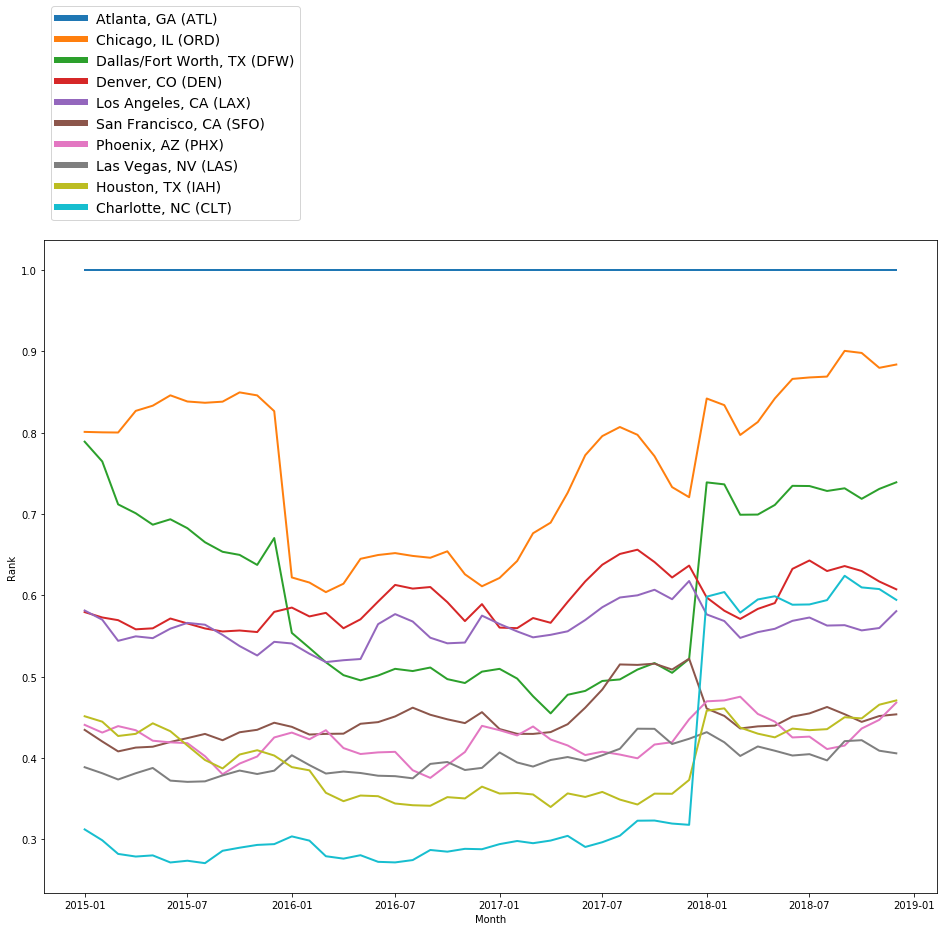

In [0]:
top_airport_count = 10

top_airports = (
    spark.read.parquet('/output/model/pagerank_all.parquet')
    .orderBy("pagerank", ascending=False)
    .limit(top_airport_count)
    .coalesce(1)
)

monthly_ranks_top = (
    spark.read.parquet('/output/model/pagerank_monthly.parquet')
    .join(
        f.broadcast(top_airports.select('id')),
        on='id',
        how='inner'
    )
)

airport_set = [(r.name, r.id) for r in top_airports.select('name','id').collect()]

# graph the monthly airport normalized pageranks

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

monthly_ranks_top_pd = monthly_ranks_top.orderBy('YearMonth').toPandas()

fig, ax = plt.subplots()

for airport in airport_set:
    rank_data = monthly_ranks_top_pd[monthly_ranks_top_pd['id'] == airport[1]]
    dates_raw = rank_data['YearMonth']
    dates = [dt.datetime.strptime(date,'%Y-%m') for date in dates_raw]
    ax.plot(
        dates,
        rank_data['normalized_rank'],
        label = '{0} ({1})'.format(airport[0], airport[1]),
        linewidth = 2
    )
    
fig.set_size_inches(16,12)
plt.xlabel("Month")
plt.ylabel("Rank")
plt.setp(plt.legend(loc='lower left', prop={'size': 14}, bbox_to_anchor=(0,1.02,1,0.2)).get_lines(), linewidth=6)    
plt.show()

In [0]:
all_airport_rank =spark.read.parquet('/output/model/pagerank_all.parquet')
colNames = ["id", "airport", "city", "country", "IATA", "ICAO", "lat", "lon", "alt", "tz", "dst", "tz_db_tz","type","source"]
air = pd.read_csv("/dbfs/FileStore/tables/open_flight_database.txt", names = colNames)

## Filter Down to just US airports
air = air.loc[air["country"]=="United States"]
## Display the airports. 
air.head()
air_dt = spark.createDataFrame(air)
air_dt.printSchema()
data_plot = all_airport_rank.join(air_dt, all_airport_rank.id == air_dt.IATA, how = 'left')

root
-- id: long (nullable = true)
-- airport: string (nullable = true)
-- city: string (nullable = true)
-- country: string (nullable = true)
-- IATA: string (nullable = true)
-- ICAO: string (nullable = true)
-- lat: double (nullable = true)
-- lon: double (nullable = true)
-- alt: long (nullable = true)
-- tz: string (nullable = true)
-- dst: string (nullable = true)
-- tz_db_tz: string (nullable = true)
-- type: string (nullable = true)
-- source: string (nullable = true)

In [0]:
import plotly.graph_objects as go
df = data_plot.toPandas()
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
#colors = ["#F9F9F5", "#FAFAE6", "#FCFCCB", "#FCFCAE",  "#FCF1AE", "#FCEA7D", "#FCD97D",
#          "#FCCE7D", "#FCC07D", "#FEB562", "#F9A648",  "#F98E48", "#FD8739", "#FE7519",
#          "#FE5E19", "#FA520A", "#FA2B0A", "#9B1803",  "#861604", "#651104", "#570303",]
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['lon'],
        lat = df['lat'],
        text = df['IATA'],
        mode = 'markers',
        marker = dict(
            size = df['pagerank']*2,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = True,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df['pagerank'],
            cmax = df['pagerank'].max(),
            colorbar_title=" Rank",
            
        )))

fig.update_layout(
        title = '2015-2018 Airport PageRank',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

## 3.6 Target Encoding
The below code is derived from https://stackoverflow.com/a/60188352/1992108

In [0]:
#Target mean encoding function
def target_mean_encoding(train_df, test_df, col, target):
    """
    :param train_df: pyspark.sql.dataframe
        training data set to apply target mean encoding
    :param test_df: pyspark.sql.dataframe
        test data set to apply target mean encodin to
    :param col: str list
        list of columns to apply target encoding
    :param target: str
        target column
    :return:
        dataframe with target encoded columns
    """

    out_suffix = ""
    grand_mean = train_df.select(f.mean(f.col(target))).collect()[0][0]

    other_train = train_df.select([c for c in train_df.columns if c not in col])
    other_test  = test_df.select([c for c in  test_df.columns if c not in col])
    target_encoded_columns_list = []
    for c in col:
        means = train_df.groupby(f.col(c)).agg(f.mean(target).alias(f"{c}_T"))
        dict_ = means.toPandas().to_dict()
        ## I want to append the keys (airline, etc.) not seen in train, but that exist in test and assign them value equal to mean of train.
        target_encoded_columns = [f.when(f.col(c) == v, encoder)
                                  for v, encoder in zip(dict_[c].values(),
                                                        dict_[f"{c}_T"].values())]
        target_encoded_columns_list.append(f.coalesce(*target_encoded_columns).alias(f"{c}{out_suffix}"))
        
    return (train_df.select(*target_encoded_columns_list,*other_train),
            test_df.select(*target_encoded_columns_list,*other_test)
                .fillna(grand_mean, subset = [c+out_suffix for c in col]))


#Target encoding data pipeline  
def target_pipe(train, test):
  '''
  User-Defined function to incorporate mean encoding and vectorization, which is a data format required for machine learning model in pyspark.ml library. 
  :param train: pyspark dataframe
    Raw training data 
  :param test : pyspark dataframe
    Raw validation or test data
  :return:
    A target-encoded, vectorized dataset.   
  '''
  
  #Identifying categorical variables 
  categoricalCol = [
    'DEST_AIRPORT_ID',
    'DAY_OF_WEEK',
    'MONTH',
    'QUARTER',
    'ORIGIN_AIRPORT_ID',
    "ORIGIN_STATE_ABR",
    "OP_CARRIER_AIRLINE_ID",
    "DEST_STATE_ABR",
    "DEP_TIME_BLK",
    "PREV_DEP_DEL",
    "PREV_ARR_DEL"] 
  
  #Identifying the outcome variable
  target = 'DEP_DEL15_RECODE'
  
  #Performing mean encoding on the train and test sets
  train,test = target_mean_encoding(train,test, categoricalCol, target)

  #Performing vectorization
  #initiate empty vector to store Pipeline Steps
  stages = []

  #Labeling the outcome variable as "label" 
  label_index = StringIndexer(inputCol = target, outputCol = 'label', handleInvalid='skip')

  #Stage the labeling var (Dep_Delay15)
  stages +=[label_index]

  #Specify the numerical columns to add into the Feature Vector.
  numCol = [
    'DISTANCE',
    "WND_DEST",
    "CIG_DEST",
    "VIS_DEST",
    "TMP_DEST",
    "DEW_DEST",
    "SLP_DEST",
    "WND_ORIGIN",
    "CIG_ORIGIN",
    "VIS_ORIGIN", 
    "TMP_ORIGIN",
    "DEW_ORIGIN",
    "SLP_ORIGIN",
    'TEMP_FREEZE_ORIGIN',
    'TEMP_FREEZE_DEST',
    'DIFF_TEMP_ORIGIN',
    'DIFF_TEMP_DEST',
    'PERCENT_CARRIER_DELAYS_24',
    'PERCENT_ORIGDEST_DELAYS_24',
    'ORIG_RECENT_FLIGHTS',
    "ARR_TIME_GAP",
    'ORI_PR',
    'DEST_PR'
  ]

  #Create a vector with only the features of interest - inclusive of the new one hot encoded features created. 
  assemblerInputs = categoricalCol + numCol


  #Pass it through the vector assembler to get the feature vector
  assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features', handleInvalid = 'skip')

  stages += [assembler]

  #Create a ML Pipeline Object and pass the stages vector created above into the pipeline
  pipeline = Pipeline(stages = stages)

  #Fit the pipeline onto the dataset - This step basically runs the pipeline specified on the airline and weather data. The output is the feature vector of interest to pass into the models. 
  fit_train, fit_test= pipeline.fit(train), pipeline.fit(test)
  
  return fit_train.transform(train), fit_test.transform(test)

# 4. Algorithm Exploration
> _Apply 2 to 3 algorithms to the training set, and discuss expectations, trade-offs, and results. These will serve as your baselines - do not spend too much time fine tuning these. You will want to use this process to select a final algorithm which you will spend your efforts on fine tuning_

For our baseline models we used Logistic Regression and a Decision Tree based on the 6 month dataset with weather and airline data. While we want higher precision than recall for the delay class, our baseline model shows precision being favored too much and thus leading to lower F1 scores. We believe that this is due to imbalanced outcome classes in the dataset. The Decision Tree model performed slightly better than the Logistic Regression model, however it tends to overfit model. On the other hand, Logistic Regression is unable to handle the fairly large amount of null values that resulted from joining the weather table. 

The delay class had an F1 score of 0.21 for both baselines. Surprisingly, removing raw weather variables did not have an impact on performance for this training data set. Assigning class weights based on training data resulted in improved recall and thus F1 scores of 0.36 and 0.21, respectively. Overall, the class weight balance provided the most benefit to both baseline models. 



We explored additional algorithms, which can be found in a separate [Final Modelling Notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120655717/command/439895120656171)

## 4.1 Undersampling

In [0]:
def undersample(train_df,ratio,class_field,base_class):
  '''
    :param train_df: pyspark.sql.dataframe
        training data set to apply class weights
    :param ratio: numerical input
        ratio to be applied to the positive class
    :param class_field: dataframe column name
        column name of the class variable to base the undersampling on
    :param base_class: numerical input
        valie of the class variable for positive cases    
    :return:
        Undersampled dataframe
   '''  
  
  #Records for delays
  pos = train_df.filter(col(class_field)==base_class)
    
  #Records for no-delays
  neg = train_df.filter(col(class_field)!=base_class)
    
  #Class counts
  total_pos = pos.count()
  total_neg = neg.count()
    
  #Creating 
  fraction=float(total_pos*ratio)/float(total_neg)
  sampled = neg.sample(False,fraction)
  return sampled.union(pos)

## 4.2 Time-based Cross Validation

In [0]:
def run_cv(model, train_raw, list_years, pipeline='none', sampling='none'):
  '''
  User-defined function to perform time-based cross validation in blocks
    :param model: pyspark.ml.classification model 
        machine learning model to be used for time-based CV
    :param train_raw: pyspark.sql.dataframe
        training data to split in blocks for time-based CV
    :param list_years: list
        list of years used for time-based CV
    :param pipeline: string
        input used to indicate the user-defined function specifying the type of data transformations to apply
    :param sampling: string
        input used to indicate the user-defined function specigying the type of sampling to apply
    :return:
        transformed trained data
        prints classification report
        prints F05, F2 scores at each iteration
        prints averaged F0.5, F1 and F2 scores        
  '''
  
  #Removes the last year in the list, as it is accounted for in the for-loop velow
  list_years.pop()
  
  #Defines empty lists to store F0.5, F1 and F2 scores at each iteration
  list_f_5_score = []
  list_f1_score = []
  list_f2_score = []
  
  #For loop that implements data transformations, sampling and divides the data in years to use for time-based CV. 
  i=1
  for y in list_years:
    start = time.time()
    train_model = train_raw.filter(train_raw['YEAR']==y)
    
    #To avoid data leakage, we remove the last two hours of the training dataset. 
    train_model = train_model.filter((train_model['HOUR_DAY_MONTH']!='22_31_12') & (train_model['HOUR_DAY_MONTH']!='23_31_12') & (train_model['HOUR_DAY_MONTH']!='24_31_12'))
    val_model = train_raw.filter(train_raw['YEAR']==y+1)
    
    #Options for feature engineering
    if pipeline == 'target_encoding':
      train_model, val_model = target_pipe(train_model, val_model)
    elif pipeline == 'none':
      train_model = PipelineModel.transform(train_model)
      val_model = PipelineModel.transform(val_model)
     
    #Sampling options
    if sampling == 'undersample':
      train_model = undersample(train_model, 1, 'DEP_DEL15_RECODE', 1)
    elif sampling == 'smote':
      train_model = smote(train_model, smote_seed=0, smote_bucketLength=2,smote_k=5,smote_multiplier=2)
    elif sampling == 'cv':
      train_model = clweight(train_model)
    elif sampling == 'none':
      pass
     
    #Fitting the model to the training data  
    fitModel = model.fit(train_model)
    
    #Evaluating the model on the validation data
    predictions = fitModel.transform(val_model)
    end = time.time()
    
    #Extracting predicted and actual labels from the validation set. 
    preds_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')
    actual = np.array(preds_and_labels.select('label').collect())
    pred = np.array(preds_and_labels.select('prediction').collect())
    
    #Printing the validation matrix
    print('**********************************************************')
    print("Iteration number:", i)
    print(classification_report(actual, pred))
    timetaken=end-start
    print('Time Taken to run: ', timetaken)
    f2 = fbeta_score(actual, pred,beta =2)
    f_5 = fbeta_score(actual, pred,beta =0.5)
    f1 = fbeta_score(actual, pred,beta =1) 
    list_f_5_score.append(f_5)
    list_f1_score.append(f1)
    list_f2_score.append(f2)
    print('F0.5 score : ', str(f_5)[:5])
    print('F2 score :', str(f2)[:5])
    print('**********************************************************')
    print(" ")
    i+=1
  
  #Printing final results 
  print("Mean F0.5 Score:", np.array(list_f_5_score).mean())  
  print("Mean F1 Score:", np.array(list_f1_score).mean())
  print("Mean F2 Score:", np.array(list_f2_score).mean())
  print("Model name", str(model))
  fitModel.write().overwrite().save('/output/model/' + str(model))
  return  train_model, str(model)
  

In [0]:
train_final = spark.read.parquet("/output/airline_weather_joined_train_full.parquet")
test_final = spark.read.parquet("/output/airline_weather_joined_test_full.parquet")

## 4.3 Logistic Regression

In [0]:
list_years = [2015, 2016, 2017, 2018]
lr = LogisticRegression(maxIter=10, elasticNetParam=0.0, tol=1e-06, regParam =0.1 ,fitIntercept=True, standardization=True )

run_cv(lr, train_final, list_years, pipeline='target_encoding', sampling='none')

**********************************************************
Iteration number: 1
 precision recall f1-score support

 0.0 0.84 1.00 0.91 4589626
 1.0 0.72 0.05 0.10 935665

 accuracy 0.84 5525291
 macro avg 0.78 0.52 0.50 5525291
weighted avg 0.82 0.84 0.77 5525291

Time Taken to run: 45.176201581954956
F0.5 score : 0.199
F2 score : 0.062
**********************************************************
 
**********************************************************
Iteration number: 2
 precision recall f1-score support

 0.0 0.83 0.99 0.91 4593982
 1.0 0.72 0.06 0.12 996682

 accuracy 0.83 5590664
 macro avg 0.77 0.53 0.51 5590664
weighted avg 0.81 0.83 0.76 5590664

Time Taken to run: 42.926390171051025
F0.5 score : 0.235
F2 score : 0.078
**********************************************************
 
**********************************************************
Iteration number: 3
 precision recall f1-score support

 0.0 0.83 0.99 0.90 5808029
 1.0 0.68 0.06 0.12 1283156

 accuracy 0.83 7091185
 macro avg 0.76 0.53 0.51 7091185
weighted avg 0.80 0.83 0.76 7091185

Time Taken to run: 48.08161163330078
F0.5 score : 0.229
F2 score : 0.076
**********************************************************
 
Mean F0.5 Score: 0.22173994175485887
Mean F1 Score: 0.1094408372116261
Mean F2 Score: 0.07265902311288681
Model name LogisticRegression_bb1897cde518
Out[6]: (DataFrame[DEST_AIRPORT_ID: double, DAY_OF_WEEK: double, MONTH: double, QUARTER: double, ORIGIN_AIRPORT_ID: double, ORIGIN_STATE_ABR: double, OP_CARRIER_AIRLINE_ID: double, DEST_STATE_ABR: double, DEP_TIME_BLK: double, PREV_DEP_DEL: double, PREV_ARR_DEL: double, DEST: string, YEAR: int, ORIGIN: string, FL_DATE: string, CRS_DEP_TIME: int, ORIGIN_CITY_MARKET_ID: int, DEP_DEL15_RECODE: int, CRS_ELAPSED_TIME: float, CRS_ARR_TIME: int, FLIGHTS: int, DISTANCE: float, DISTANCE_GROUP: int, HOUR_DAY_MONTH: string, ARR_TIME_GAP: float, PREV_DEP_DEL_RECODE: double, PREV_ARR_DEL_RECODE: double, PERCENT_CARRIER_DELAYS_24: float, PERCENT_ORIGDEST_DELAYS_24: float, ORIG_RECENT_FLIGHTS: int, FL_WEEKEND: int, TIME_OF_DAY: int, WND_ORIGIN: double, CIG_ORIGIN: double, VIS_ORIGIN: double, TMP_ORIGIN: double, DEW_ORIGIN: double, SLP_ORIGIN: double, WND_DEST: double, CIG_DEST: double, VIS_DEST: double, TMP_DEST: double, DEW_DEST: double, SLP_DEST: double, ORI_PR: float, DEST_PR: float, TEMP_FREEZE_ORIGIN: int, TEMP_FREEZE_DEST: int, DIFF_TEMP_ORIGIN: float, DIFF_TEMP_DEST: float, label: double, features: vector],
 'LogisticRegression_bb1897cde518')

## 4.4 Decision Trees

In [0]:
list_years = [2015, 2016, 2017, 2018]
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

#Initiate the decision tree classifier - Hyperparameter tuning 
dt.setMaxDepth(7)\
  .setMaxBins(5)\
  .setMinInstancesPerNode(5)\
  .setMinWeightFractionPerNode(1e-5)\
  .setThresholds([0.5, 0.5])

run_cv(dt, train_final, list_years, pipeline='target_encoding', sampling='none')

**********************************************************
Iteration number: 1
 precision recall f1-score support

 0.0 0.87 0.97 0.92 4589626
 1.0 0.71 0.30 0.42 935665

 accuracy 0.86 5525291
 macro avg 0.79 0.64 0.67 5525291
weighted avg 0.84 0.86 0.84 5525291

Time Taken to run: 47.86310410499573
F0.5 score : 0.552
F2 score : 0.334
**********************************************************
 
**********************************************************
Iteration number: 2
 precision recall f1-score support

 0.0 0.87 0.97 0.92 4593982
 1.0 0.71 0.32 0.44 996682

 accuracy 0.85 5590664
 macro avg 0.79 0.64 0.68 5590664
weighted avg 0.84 0.85 0.83 5590664

Time Taken to run: 47.4202401638031
F0.5 score : 0.566
F2 score : 0.354
**********************************************************
 
**********************************************************
Iteration number: 3
 precision recall f1-score support

 0.0 0.86 0.97 0.91 5808029
 1.0 0.70 0.31 0.43 1283156

 accuracy 0.85 7091185
 macro avg 0.78 0.64 0.67 7091185
weighted avg 0.84 0.85 0.83 7091185

Time Taken to run: 47.72691082954407
F0.5 score : 0.563
F2 score : 0.352
**********************************************************
 
Mean F0.5 Score: 0.5606759477782836
Mean F1 Score: 0.428816620053291
Mean F2 Score: 0.34720257684481814
Model name DecisionTreeClassifier_1a99d960711b
Out[9]: (DataFrame[DEST_AIRPORT_ID: double, DAY_OF_WEEK: double, MONTH: double, QUARTER: double, ORIGIN_AIRPORT_ID: double, ORIGIN_STATE_ABR: double, OP_CARRIER_AIRLINE_ID: double, DEST_STATE_ABR: double, DEP_TIME_BLK: double, PREV_DEP_DEL: double, PREV_ARR_DEL: double, DEST: string, YEAR: int, ORIGIN: string, FL_DATE: string, CRS_DEP_TIME: int, ORIGIN_CITY_MARKET_ID: int, DEP_DEL15_RECODE: int, CRS_ELAPSED_TIME: float, CRS_ARR_TIME: int, FLIGHTS: int, DISTANCE: float, DISTANCE_GROUP: int, HOUR_DAY_MONTH: string, ARR_TIME_GAP: float, PREV_DEP_DEL_RECODE: double, PREV_ARR_DEL_RECODE: double, PERCENT_CARRIER_DELAYS_24: float, PERCENT_ORIGDEST_DELAYS_24: float, ORIG_RECENT_FLIGHTS: int, FL_WEEKEND: int, TIME_OF_DAY: int, WND_ORIGIN: double, CIG_ORIGIN: double, VIS_ORIGIN: double, TMP_ORIGIN: double, DEW_ORIGIN: double, SLP_ORIGIN: double, WND_DEST: double, CIG_DEST: double, VIS_DEST: double, TMP_DEST: double, DEW_DEST: double, SLP_DEST: double, ORI_PR: float, DEST_PR: float, TEMP_FREEZE_ORIGIN: int, TEMP_FREEZE_DEST: int, DIFF_TEMP_ORIGIN: float, DIFF_TEMP_DEST: float, label: double, features: vector],
 'DecisionTreeClassifier_1a99d960711b')

## 4.5 Gradient-Boosted Trees

In [0]:
list_years = [2015, 2016, 2017, 2018]
gbt = GBTClassifier(featuresCol="features", labelCol='label' ,stepSize =0.1,maxIter=10 , maxDepth=5) 
gbt.setThresholds([0.5, 0.5])
run_cv(gbt, train_final, list_years, pipeline='target_encoding', sampling='none')

**********************************************************
Iteration number: 1
 precision recall f1-score support

 0.0 0.88 0.97 0.92 4589626
 1.0 0.71 0.34 0.46 935665

 accuracy 0.86 5525291
 macro avg 0.79 0.65 0.69 5525291
weighted avg 0.85 0.86 0.84 5525291

Time Taken to run: 60.88812232017517
F0.5 score : 0.581
F2 score : 0.376
**********************************************************
 
**********************************************************
Iteration number: 2
 precision recall f1-score support

 0.0 0.87 0.97 0.92 4593982
 1.0 0.70 0.36 0.48 996682

 accuracy 0.86 5590664
 macro avg 0.79 0.66 0.70 5590664
weighted avg 0.84 0.86 0.84 5590664

Time Taken to run: 57.862441062927246
F0.5 score : 0.588
F2 score : 0.399
**********************************************************
 
**********************************************************
Iteration number: 3
 precision recall f1-score support

 0.0 0.87 0.96 0.92 5808029
 1.0 0.69 0.37 0.48 1283156

 accuracy 0.86 7091185
 macro avg 0.78 0.67 0.70 7091185
weighted avg 0.84 0.86 0.84 7091185

Time Taken to run: 58.794201135635376
F0.5 score : 0.585
F2 score : 0.405
**********************************************************
 
Mean F0.5 Score: 0.5851726632181681
Mean F1 Score: 0.47075538945701845
Mean F2 Score: 0.39388742104773034
Model name GBTClassifier_2519e70e6837
Out[8]: (DataFrame[DEST_AIRPORT_ID: double, DAY_OF_WEEK: double, MONTH: double, QUARTER: double, ORIGIN_AIRPORT_ID: double, ORIGIN_STATE_ABR: double, OP_CARRIER_AIRLINE_ID: double, DEST_STATE_ABR: double, DEP_TIME_BLK: double, PREV_DEP_DEL: double, PREV_ARR_DEL: double, DEST: string, YEAR: int, ORIGIN: string, FL_DATE: string, CRS_DEP_TIME: int, ORIGIN_CITY_MARKET_ID: int, DEP_DEL15_RECODE: int, CRS_ELAPSED_TIME: float, CRS_ARR_TIME: int, FLIGHTS: int, DISTANCE: float, DISTANCE_GROUP: int, HOUR_DAY_MONTH: string, ARR_TIME_GAP: float, PREV_DEP_DEL_RECODE: double, PREV_ARR_DEL_RECODE: double, PERCENT_CARRIER_DELAYS_24: float, PERCENT_ORIGDEST_DELAYS_24: float, ORIG_RECENT_FLIGHTS: int, FL_WEEKEND: int, TIME_OF_DAY: int, WND_ORIGIN: double, CIG_ORIGIN: double, VIS_ORIGIN: double, TMP_ORIGIN: double, DEW_ORIGIN: double, SLP_ORIGIN: double, WND_DEST: double, CIG_DEST: double, VIS_DEST: double, TMP_DEST: double, DEW_DEST: double, SLP_DEST: double, ORI_PR: float, DEST_PR: float, TEMP_FREEZE_ORIGIN: int, TEMP_FREEZE_DEST: int, DIFF_TEMP_ORIGIN: float, DIFF_TEMP_DEST: float, label: double, features: vector],
 'GBTClassifier_2519e70e6837')

# 5. Algorithm Implementation
> _Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform. Apply your algorithm to the training dataset and evaluate your results on the test set._

## 5.1. Toy Example

This section demonstrates the underlying algorithm used to build our final Gradient Boosted Tree Classifier using a short example.

### 5.1.1. Basic Tree Algorithm

In order to build a Boosted Tree Classifier, you first have to build a basic tree. Here is our implementation of the algorithm to build such a tree. The basic algorithm is as follows (modified from Daume p. 13)

![Decision Tree Algorithm](https://raw.githubusercontent.com/blulightspecial/images/main/DecisionTreeAlgo.png)

### 5.1.2. Toy Example (By hand)
To demonstrate the power of the boosted tree, we created a "Toy" example. Like our full example, we are predicting whether or not a flight will be delayed by more than 15 minutes `DEP_DEL_15`. We use 2 features to help predict this, the layover time `AIR_TIME_GAP`, and whether the previous flight was delayed or not `PREV_DEP_DEL`. An example by hand  is shown below:

![Toy Example By Hand](https://raw.githubusercontent.com/blulightspecial/images/main/ToyExampleHand.jpg)

### 5.1.3. Basic Tree Code

This section provides code to build the basic decision tree in python. We are able to replicate the above example.

In [0]:
# create the TreeNode class below
class TreeNode(object):
    def __init__(self, value, left, right):
        self.value = value # prediction if this is a leaf, (colName, splitValue) if it's not a leaf
        self.left = left   # left subtree. None if this is a leaf.
        self.right = right # right subtree. None if this is a leaf.

def trainTree(data,target,verbose=False):
#   print("nunique", data[target].nunique())
#   display(data)
  
  if list(data.columns) == [target]: # if there's no feature columns left return leaf with majority class
    if verbose:
      print("Leaf encountered (no features left)")
    return TreeNode(np.round(data[target].mean()),None, None)
  elif data[target].nunique() == 1: # if there's only one typer of target value left return leaf with that number
    if verbose:
      print("Leaf encountered (single target type)")
    return TreeNode(data[target][0],None,None)    
  else:
    (sCol, sVal, ig) = chooseSplit(data, target)
    if verbose:
      print("Tree split on",sCol,"at",sVal,". Info gain =",ig)
    l_data = data.loc[data[sCol] <  sVal, [c for c in data.columns if c != sCol]]
    r_data = data.loc[data[sCol] >= sVal, [c for c in data.columns if c != sCol]]
    return TreeNode((sCol,sVal), trainTree(l_data,target,verbose), trainTree(r_data,target,verbose))

def chooseSplit(data, target):
  
  ## get potential split locations
  pSplit = potential_splits(data,target)
  
  ## set an tuple to collect the best split (field name, split location, info gain)
  best_split = ("empty_val", 0, -1)
  
  ## get initial variance of the target as a whole
  var_init = data[target].var()
  len_init = data[target].size
  
  ## Choose best split location (info gain with variance impurity measure)
  for ii in pSplit:
    for jj in pSplit[ii]:
      l_series = data.loc[data[ii]<jj,target]
      len_l = l_series.size
      var_l = 0 if len_l == 1 else l_series.var()      
      r_series = data.loc[data[ii]>=jj,target]
      len_r = r_series.size
      var_r = 0 if len_r == 1 else r_series.var()
      info_gain = var_init - (len_l/len_init) * var_l - (len_r/len_init) * var_r
#       print(ii,jj,var_init,var_l,var_r, info_gain)
      if info_gain > best_split[2]:
        best_split = (ii, jj, info_gain)
  
  ## return our best split tuple after all splits have beeen evaluated
  return best_split

def potential_splits(data, target):
  cSet = set(data.columns)
  cSet.remove(target)
  # initially sort on delay values. If we use stable sorts later (mergesort), then we can guarantee that any row to row change in our variable of interest will line up with a row-to-row change in the target variable.
  sdata = data.sort_values(target)
  retDict = dict()
  for c in cSet:
    ## find entries where both the variable being investigated and the target are different than the 1 above. We know these will line up because we sorted on target above and we are using (stable) mergesort below.
    sortedData = sdata.loc[:,[target,c]].sort_values(c,kind="mergesort")
    split_mgs = sortedData.diff().product(axis=1,skipna=False) # a non-zero value here means entry is different than one above (we should investigate splitting there)
    retDict[c] = sortedData[c].subtract(split_mgs.abs()/2)[-split_mgs.isnull() & split_mgs!=0].to_list()
  
  return retDict

def predictTree(data,model):
  retList = []
  for row in data.itertuples():
    retList.append(predictRow(row._asdict(),model))

  return retList
    
def predictRow(row, tree):
  if (tree.left == None) & (tree.right == None): #we're at a leaf return the prediction
    return tree.value
  else:                                    #we're not at a leaf pull out predictor stuff
#     print(tree.value)
    sCol,sVal = tree.value
  
#   print(row)
  if row[sCol] < sVal:
    return predictRow(row, tree.left)
  else:
    return predictRow(row, tree.right)

#### Build and Verify Model

In [0]:
## Create and display the toy training data set
toy_train = pd.DataFrame({"DEP_DEL15":[1,1,1,0,0,0,0,0],
                       "PREV_DEP_DEL":[1,0,0,0,1,0,0,0],
                       "AIR_TIME_GAP":[15,2,35,40,68,30,90,28]})

## Build a toy test data set. (built so model will predict it correctly if it's working as it should)
toy_test = pd.DataFrame({"DEP_DEL15":[1,0],
                     "PREV_DEP_DEL":[0,1],
                     "AIR_TIME_GAP":[21,22]})

## Build the model
model = trainTree(toy_train,"DEP_DEL15",verbose=True)

Tree split on AIR_TIME_GAP at 21.5 . Info gain = 0.14285714285714285
Leaf encountered (single target type)
Tree split on PREV_DEP_DEL at 0.5 . Info gain = -5.551115123125783e-17
Leaf encountered (no features left)
Leaf encountered (no features left)

In [0]:
## Verify that The test is returning expected values
  # They'll match DEP_DEL_15 if it's working.
predicted = predictTree(toy_test,model)

toy_test_out = toy_test.copy()
toy_test_out["PREDICTIONS"] = predicted

print("Test predictions should match DEP_DEL15")
display(toy_test_out)

Test predictions should match DEP_DEL15

DEP_DEL15,PREV_DEP_DEL,AIR_TIME_GAP,PREDICTIONS
1,0,21,1.0
0,1,22,0.0


In [0]:
## Verify that The test is returning expected values
  # PREDICTIONS will match DEP_DEL_15 except at the 35 minute observation if it's working.

predicted = predictTree(toy_train,model)

toy_train_out = toy_train.copy()
toy_train_out["PREDICTIONS"] = predicted

print("Test predictions should match DEP_DEL15")
display(toy_train_out)

Test predictions should match DEP_DEL15

DEP_DEL15,PREV_DEP_DEL,AIR_TIME_GAP,PREDICTIONS
1,1,15,1.0
1,0,2,1.0
1,0,35,0.0
0,0,40,0.0
0,1,68,0.0
0,0,30,0.0
0,0,90,0.0
0,0,28,0.0


### 5.1.4. Gradient Boost

**Why Boost?**

Gradient boost and boosting in general uses an ensemble of predictors to make better predictions than a single predictor would. It is able to do this by iteratively adding on predictors and increasing the importance of observations that the previous predictor failed to classify correctly. By doing this, we end up with an group of models that has different "specialties". Even though any individual model might not be very good (in many cases the classifier is a stump (single level tree), the group as a whole is able to make good predictions becasue a variety of inputs are being considered and the models are built intentionally so that they are weak in different areas.

**Spark's Implementation of Gradient Boost**

In its `GBTClassifier()` spark uses the Stochatic Gradient Boost algorithm that was proposed by Friedman in 1991 ([source](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf)). One of the innovations of this implementation is that in addition to the typical ensemble performance of boosting, it explicitly leverages random sampling. Instead of training each tree in the ensemble on the whole data set, each tree is trained on a portion of the data. This exposes the algorithm to more different types of data and makes the results more generalizable. The algorithm proposed in the paper is as follows:

![Algorithm from Friedman](https://raw.githubusercontent.com/blulightspecial/images/main/StochasticGBTAlgo.png)

**Attempted Toy Implementation of Boost**

After a few days trying to get meaning from and determine an implementation for Freidman's Gradient Boost algorithm we realized that we were not going to be able to understand it well enough to code it up in time for submission. We searched for other flavors of boosing that we could implement to deomstrate its value. We implemented a version of the boosting algorithm from _Introductoin to Statistical Learning_ ([source](https://www.statlearning.com)). The algorithm is shown here, the code is shown below. Unfortunately, after we checked the results, we saw that it wasn't working the way that we expected it to. Fundamentally, this was a regression algorithm that we were attempting to use on a classifier and it would not work. There's definitely something happening. Points that are objectively more likely to be delayed have higher score, but

![Boost Algo from Intorducton to Statistical Learning](https://raw.githubusercontent.com/blulightspecial/images/main/ISLBoost.png)

**What Went Wrong and What We would Need to Implement for Working Toy Gradient Boost**

* Base Tree Model
  * I think I ought to have changed the internal encoding for "in-class"/"out-of-class" to +1/-1 instead of the 1/0 that I'm using now. In a lot of machine learning problems the default is  +1/- instead of 0/1 to make the math work out. In this lecture on boosting ([link](https://www.youtube.com/watch?v=UHBmv7qCey4)) MIT Professor Patrick Winston goes through some of the math and uses +1/-1 thoughout. I can't help but think that my regresion implementation of boost might work if we did this.
* Loss function
  * I need a logistic loss function in there. This is what professor Winston uses in his lecture. It's also mentioned in the spark documentation that the loss function that you must select when using a classifier tree is the logistic loss. 
* Gradient
  * I need to take the gradient, but I couldn't really comprehend what tha twould lok like for our 1,0 binary output. I guess if we're using the logistic loss though, that woudl be differntialble over it's domain, so that has got to have something to do with it.

In [0]:
def train_boost(data, target, shrinkage, num_trees, depth, verbose = True):
  resid = np.array(data[target].tolist())
  pred = [0]*data.shape[0]
  trees = []
  
  for ii in range(num_trees):
    ## copy the data for a run. 
    dataTemp = data.copy()
    
    ## set the new residual target to match 
    dataTemp[target] = resid
    
    ## set max depth by randomly pulling "depth" features to use in training
    feature_cols = random.sample([c for c in dataTemp.columns.tolist() if c != target],depth)
    dataTemp = dataTemp[[target,*feature_cols]]
    
    ## train up the tree to target the residual
    trees.append(trainTree(dataTemp,target))
    
    ## get predictions from the tree
    resid = resid - (shrinkage * np.array(predictTree(dataTemp,trees[ii])))
    
  
  return (trees, shrinkage, num_trees)

def predict_boost(data, model):
  pred = np.array([0]*data.shape[0])
  for ii in range(model[2]):
    pred = pred + (model[1] * np.array(predictTree(data,model[0][ii])))
  return pred

## need to append data for interesting things to happen. 
  ## In my initial data set, spltting on PREV_DEP_DEL never caused unique L/R split majorities.

toy_train2 = toy_train.append({"DEP_DEL15":1,"PREV_DEP_DEL":1,"AIR_TIME_GAP":29}, ignore_index=True)

random.seed(13)
model = train_boost(toy_train2, "DEP_DEL15", 0.03, 500, 1)

predicted = predict_boost(toy_train2,model)

toy_train2["PREDICTIONS"] = predicted

print(predicted)
display(toy_train2)

toy_train2.drop(columns=["PREDICTIONS"], inplace=True)

[0.33 0.18 0.12 0. 0.15 0.12 0. 0.12 0.27]

DEP_DEL15,PREV_DEP_DEL,AIR_TIME_GAP,PREDICTIONS
1,1,15,0.33000000000000007
1,0,2,0.18
1,0,35,0.12
0,0,40,0.0
0,1,68,0.15
0,0,30,0.12
0,0,90,0.0
0,0,28,0.12
1,1,29,0.27


### 5.1.A. References

* **Spark Documentation**
  * GBT in the classification and regression overview ([link](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier))
  * GBT input-output in the classification and regression section ([link](https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-trees-gbts))
  * GBT in the ensemble modeling section (_with examples_) ([link](https://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts))
  * API reference (_python_) for `GBTClassifier()` ([link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html))
  * Source code (_python_) for `GBTClassifier()` ([link](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/classification.html#GBTClassifier))
  * Source code (_scala_) for `GBTClassifier()` (this is where it says that variance is the impurity meausre used by GBT) ([link](https://github.com/apache/spark/blob/v3.1.1/mllib/src/main/scala/org/apache/spark/ml/classification/GBTClassifier.scala))
  * Various possible impurity measures in spark Decision Trees ([link](https://spark.apache.org/docs/1.3.0/mllib-decision-tree.html))
* **Academic Sources**
  * _Stochastic Gradient Boosting_, J.H. Friedman, 1999,  ([link](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf))
    * This Paper serves as the source for spark's implementation of gradient boost
* **Other References**
  * _Gradient Boosting_ article on Wikipedia is referenced in the source code ([link](https://en.wikipedia.org/wiki/Gradient_boosting))
  * _A Course in Machine Learning_, Hal Daume (2017) [ciml.info](http://www.ciml.info)

## 5.2. Full Model

### 5.2.1 Evaluation function

In [0]:
def evaluate(model, model_load, train_raw, test_raw):
  '''
  User-defined function that evaluates a trained model on a test dataset. This function assumes that the best model is achieved using target encoding and  undersampling, which are applied by default on the input data. 
  
  :param model: string entry 
      One of the options only are allowed: lr, dt, gbt, lsvc, rf
  :model_load: string entry
      Saved model name to be used to retrieve the model from dbfs. 
  :train_raw: pyspark dataframe
      Raw training data to be used to fit the data pipeline
  :test_raw: pyspark dataframe
      Raw test data to be used for evaluation of the machine learning model
  :pipeline: string entry
      input used to indicate the user-defined function specifying the type of data transformations to apply
  '''
  
  if model == 'lr':
    fitModel = LogisticRegressionModel.load('/output/model/' + model_load)
  elif model == 'dt':
    fitModel = DecisionTreeClassificationModel.load('/output/model/' + model_load)
  elif model == 'rf':
    fitModel = RandomForestClassificationModel.load('/output/model/' + model_load)
  elif model == 'gbt':
    fitModel = GBTClassificationModel.load('/output/model/' + model_load)
  elif model == 'lsvc':
    fitModel = LinearSVCModel.load('/output/model/' + model_load)
  else: 
    print("Please enter one of the following string options: lr, gbt, rf, dt, lsvc")
  
  
  train, test = target_pipe(train_raw, test_raw)
  
  #Evaluating the test set
  predictions = fitModel.transform(test)
  
  #Extracting predicted and actual labels
  preds_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')
  actual = np.array(preds_and_labels.select('label').collect())
  pred = np.array(preds_and_labels.select('prediction').collect())
  print('**********************************************************')
  print("Evaluation report for the test set")
  print(classification_report(actual, pred))
  f2 = fbeta_score(actual, pred,beta =2)
  f_5 = fbeta_score(actual, pred,beta =0.5)
  f1 = fbeta_score(actual, pred,beta =1) 
  print('F 0.5 score : ', str(f_5)[:5])
  print('F 2 score :', str(f2)[:5])
  print('**********************************************************') 
  return actual, pred

### 5.2.3 Time-Based Cross-Validation

In [0]:
list_years = [2015, 2016, 2017, 2018]
gbt = GBTClassifier(featuresCol="features", labelCol='label' ,stepSize =0.1,maxIter=50 , maxDepth=5) 
gbt.setThresholds([0.2, 0.8])
train_model, model_name = run_cv(gbt, train_final, list_years, pipeline='target_encoding', sampling='undersample')

**********************************************************
Iteration number: 1
 precision recall f1-score support

 0.0 0.88 0.97 0.92 4589626
 1.0 0.69 0.37 0.48 935665

 accuracy 0.87 5525291
 macro avg 0.79 0.67 0.70 5525291
weighted avg 0.85 0.87 0.85 5525291

Time Taken to run: 120.98231410980225
F0.5 score : 0.588
F2 score : 0.404
**********************************************************
 
**********************************************************
Iteration number: 2
 precision recall f1-score support

 0.0 0.88 0.96 0.92 4593982
 1.0 0.67 0.40 0.50 996682

 accuracy 0.86 5590664
 macro avg 0.78 0.68 0.71 5590664
weighted avg 0.84 0.86 0.84 5590664

Time Taken to run: 118.90086102485657
F0.5 score : 0.592
F2 score : 0.434
**********************************************************
 
**********************************************************
Iteration number: 3
 precision recall f1-score support

 0.0 0.88 0.96 0.92 5808029
 1.0 0.67 0.40 0.50 1283156

 accuracy 0.86 7091185
 macro avg 0.78 0.68 0.71 7091185
weighted avg 0.84 0.86 0.84 7091185

Time Taken to run: 129.74124193191528
F0.5 score : 0.590
F2 score : 0.433
**********************************************************
 
Mean F0.5 Score: 0.5906649533544842
Mean F1 Score: 0.49349587549715473
Mean F2 Score: 0.4239450428019957
Model name GBTClassifier_2a79ee980f7c

### 5.2.4 Evaluation

In [0]:
actual, pred = evaluate('gbt', model_name, train_final, test_final)

**********************************************************
Evaluation report for the test set
 precision recall f1-score support

 0.0 0.88 0.95 0.91 5897595
 1.0 0.66 0.41 0.51 1324316

 accuracy 0.85 7221911
 macro avg 0.77 0.68 0.71 7221911
weighted avg 0.84 0.85 0.84 7221911

F 0.5 score : 0.591
F 2 score : 0.448
**********************************************************

#### 5.2.4.1 Confusion Matrix

Out[13]:

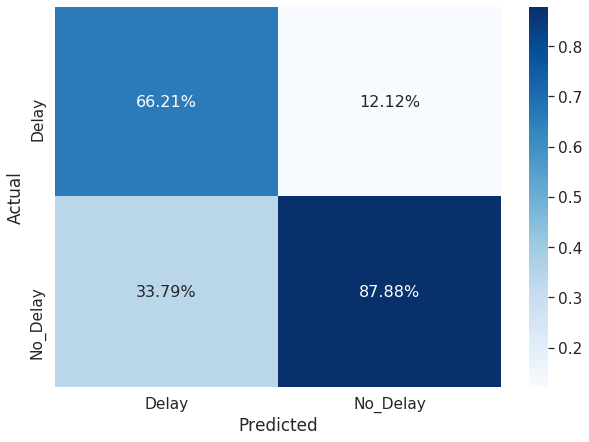

<matplotlib.axes._subplots.AxesSubplot at 0x7fba6ed89450>

In [0]:
y_true = np.where(actual == 0.0, 'No_Delay', 'Delay')
y_pred = np.where(pred == 0.0, 'No_Delay', 'Delay')
#y_true = actual
#y_pred = pred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm/np.sum(df_cm), fmt='.2%',cmap="Blues", annot=True,annot_kws={"size": 16})# font size

#### 5.2.4.2 Feature Importance

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
  '''
  Extracts the top 10 most important features to understand the relative importance of each feature in our prediction model.
  :param featureImp: Pyspark sparse vector
      Importance scores calculated based on a given machine learning model performance.
  :dataset: pyspark dataframe
      Training dataset
  :featuresCol: list 
      List of Pyspark dataframe columns to consider for feature importance assessment
  :return:
      Ranked list of features based on their importance score. 
  '''
  list_extract = []
  for i in train_model.schema[featuresCol].metadata["ml_attr"]["attrs"]:
      list_extract = list_extract + train_model.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
  varlist = pd.DataFrame(list_extract)
  varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
  return(varlist.sort_values('score', ascending = False))


In [0]:
gbtModel = GBTClassificationModel.load('/output/model/' + model_name)
importances = gbtModel.featureImportances
find_deature = ExtractFeatureImp(importances, train_model, "features")
top_10_features = find_deature.nlargest(10,'score')
print(top_10_features)

idx name score
31 31 ARR_TIME_GAP 0.226947
9 9 PREV_DEP_DEL 0.183528
28 28 PERCENT_CARRIER_DELAYS_24 0.121248
8 8 DEP_TIME_BLK 0.068214
0 0 DEST_AIRPORT_ID 0.056455
4 4 ORIGIN_AIRPORT_ID 0.044681
11 11 DISTANCE 0.027396
30 30 ORIG_RECENT_FLIGHTS 0.026788
19 19 CIG_ORIGIN 0.025594
13 13 CIG_DEST 0.024297

# 6. Conclusions
> _Report results and learnings for both the ML as well as the scalability._

We were able to successfully combine weather and airline data, engineer eight additional variables and explore various techniques (e.g.: class weights, undersampling, and smote) to counter-balance the fact that our delay outcome is highly skewed. We used predicition algorithms (e.g.: logistic regression, decision trees, random forest, etc.) to predict delayed flights two hours before their depature. Our best performing model, gradient boosted decision trees, was fine tuned using techniques such as varying the number of trees, the depth of trees and applying thresholds. Using 2019 joined weather and flight data as our test set, our GBT model  achieved an F 0.5 score of 0.59.
Based on our confusion matrix, we note that our model only mis-classified 12% of non-delayed flights as delays. From a business perspective, this means that airline companies are not likely to announce a delayed flight when it is actually on time - which was one of our goals. However, our model misclassified about a third of delayed flights, so not entirely managing to reduce costs related to delays. From a passenger perspective, this also means that passengers will still experience frustrating delays at the boarding gate. However, a third of delayed flights in this datasets represents about 6% of all flights, which still represents an improvement from not implementing any models. 
There are three clear areas of improvement for our model: 
1. Continue to identify ways to increase our current F0.5 score, either via feature engineering or more model fine-tuning. 
2. Work on making our pipeline run faster. At this point our entire pipeline runs, but we note that the cluster gets slower as more information gets stored into memory. 
3. Make our pipeline ready for production by identifying how it could incorporate real-time flight data via streaming mechanisms, like Kafka queues.

# 7. Application of Course Concepts
> _Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts_

**Course Concepts**
- Broadcasting : 
In PySpark RDD and DataFrame, Broadcast variables are read-only shared variables that are cached and available on all nodes in a cluster in-order to access or use by the tasks. Instead of sending this data along with every task, PySpark distributes broadcast variables to the workers using efficient broadcast algorithms to reduce communication costs. Broadcast variables are used to save the copy of data across all nodes for parallel processing. Broadcast joins are perfect for joining a large DataFrame with a small DataFrame. Splits up data on different nodes in a cluster so multiple computers can process data in parallel. Traditional joins are hard with Spark because the data is split. Broadcast joins are easier to run on a cluster. Spark can “broadcast” a small DataFrame by sending all the data in that small DataFrame to all nodes in the cluster. After the small DataFrame is broadcasted, Spark can perform a join without shuffling any of the data in the large DataFrame. Our use case is broasting top 10 highest rank airpot ID and joining them with monthly rank which contain each airport’s monthly traffic rank. Although these two tables are relatively small, it is a good practice for broaching join and we could ,in the future, implemented it in large data set join function. 
 

- PageRank : PageRank works by counting the number and quality of edges to a node to determine a rough estimate of how important the node is.We implemented pagerank on airline data to get airline business for departure delay prediction. In order to predict delays, it was important to capture a variable that was able to display the level of traffic taking place at each airport. PageRank is flexible enoguh that it allowed us to fine tune how we defined nodes (airports) and edges (number of flights) to get to more granular definitions of "traffic". For instance, implementing monthly PageRank allowed us to explore seasonal variation in airport traffic. 

- Functional programming: We developed a variety of functions to be included into other functions. This cleaned our data pipeline and made it reusable with other datasets, since our pipeline does not depend on the state of a dataset to run, but only depends on initial input parameters. One example is when we defined a mean target encoding function to be included in another data pipeline function to vectorize our training data and prepare our machine learning model inputs. 

- Cross-Validation: We used time-based cross-validation to perform hyperparameter tuning on our models and ensure robust validation results that closely matched test results. Had we not used cross-validation, we would have fine-tuned our model based on single samples of train and validation data, it would not have generalized well when testing the model performance on unseen data. The fitting and validation of the model would have been tied to the specific train and validation samples selected. 

- L1 and L2 linearization: We used L1 and L2 linearization in our hyperparameter tuning of logistic regression, in order to avoid overfitting. We identified early on that L2 was the linearization we wanted to use, as our feature space was already reduced via target encoding.

# A.1. Additional sources
This might be useful in matching station codes to airports:
1. http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html
2. https://www.world-airport-codes.com/
3. https://openflights.org/data.html

# A.2. References
## Cost/Impact of Delays
1. https://www.airlines.org/data/annual-u-s-impact-of-flight-delays-nextor-report/
2. https://cpb-us-e1.wpmucdn.com/blog.umd.edu/dist/9/604/files/2019/09/TDI_Report_Final_11_03_10.pdf
3. https://www.faa.gov/data_research/aviation_data_statistics/media/cost_delay_estimates.pdf
4. https://www.bts.gov/newsroom/2019-annual-and-4th-quarter-us-airline-financial-data

## Flight Delay Papers and Articles
1. [A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines](https://arxiv.org/pdf/1903.06740.pdf)
2. [Chained Predictions of Flight Delay Using Machine Learning](https://junchen.sdsu.edu/proceedings/scitech_gnc19_Chen.pdf)
3. [Predictive Modelling: Flight Delays and Associated Factors, Hartsfield–Jackson Atlanta International Airport](https://www.sciencedirect.com/science/article/pii/S1877050918317319)
4. [Using Machine Learning to Predict Flight Delays](https://medium.com/analytics-vidhya/using-machine-learning-to-predict-flight-delays-e8a50b0bb64c)
5. [A Statistical Approach to Predict Flight Delay Using Gradient Boosted Decision Tree](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8272656)
6. [Prediction of Weather-induced Airline Delays Based on Machine Learning Algorithms](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7777956)
7. [Flight delay prediction for commercial air transport: A deep learning approach](https://www.sciencedirect.com/science/article/pii/S1366554518311979)
8. [Generalized Flight Delay Prediction Method Using Gradient Boosting Decision Tree](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9129110Title)

## Imbalanced Data
1. https://www.jeremyjordan.me/imbalanced-data/
2. [Undersampling Function](https://stackoverflow.com/questions/53978683/how-to-undersampling-the-majority-class-using-pyspark)
3. [SMOTE Function](https://gist.github.com/hwang018/420e288021e9bdacd133076600a9ea8c)